In [1]:
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class MultiTaskDataset(Dataset):
    def __init__(self, label_dir, image_dir, transform=None):
        self.label_dir = label_dir
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        label_folders = sorted(os.listdir(label_dir))
        image_folders = sorted(os.listdir(image_dir))

        for label_folder, image_folder in zip(label_folders, image_folders):
            label_subdir = os.path.join(label_dir, label_folder)
            image_subdir = os.path.join(image_dir, image_folder)

            if os.path.isdir(label_subdir) and os.path.isdir(image_subdir):
                for file in os.listdir(label_subdir):
                    if file.endswith(".json"):
                        json_path = os.path.join(label_subdir, file)
                        with open(json_path, "r") as f:
                            try:
                                data = json.load(f)
                                image_filename = f"{data['filename']}.{data['format']}"
                                image_path = os.path.join(image_subdir, image_filename)

                                if os.path.exists(image_path):
                                    data["image_path"] = image_path
                                    self.data.append(data)
                                else:
                                    print(f"Image not found: {image_path}")
                            except json.JSONDecodeError as e:
                                print(f"Error loading JSON {json_path}: {e}")

        print(f"Total samples loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image_path"]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        age = torch.tensor(item["age_past"] / 100.0, dtype=torch.float32)
        gender = torch.tensor(0 if item["gender"] == "male" else 1, dtype=torch.float32)

        return image, age, gender



In [2]:
image_dir = "/home/hyun/dev_ws/ROS_project/age/Training/images"
label_dir = "/home/hyun/dev_ws/ROS_project/age/Training/labels"


In [3]:
transform_with_padding = transforms.Compose([
    transforms.Resize((224, 224)),  # 고정 크기로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
# 데이터셋 생성
dataset_with_padding = MultiTaskDataset(label_dir, image_dir, transform=transform_with_padding)

# DataLoader 생성
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset_with_padding, batch_size=32, shuffle=True)

# 데이터 확인
for images, ages, genders in dataloader:
    print(f"Image batch shape: {images.shape}")  # [batch_size, channels, height, width]
    print(f"Age batch: {ages}")
    print(f"Gender batch: {genders}")
    break


Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000050_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000048_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000049_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_15_00000005_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_06_00000046_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_36_00000038_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_25_00000019_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000009_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000012_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_004

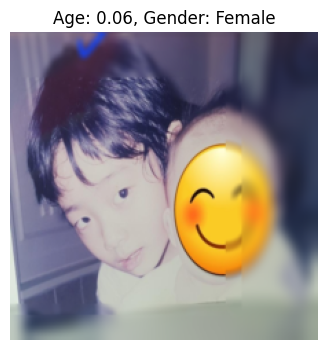

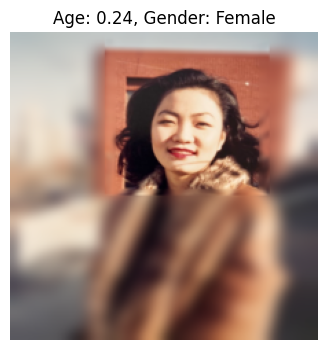

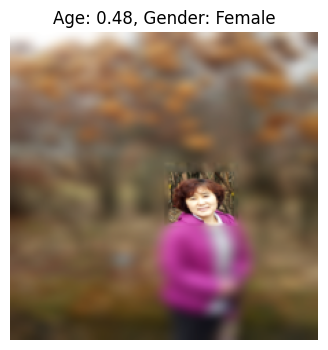

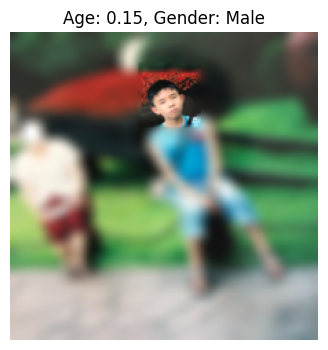

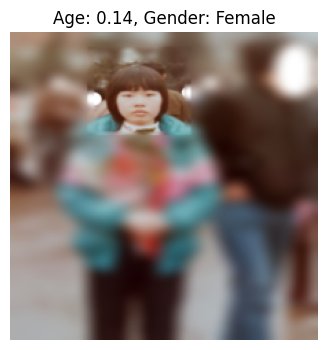

In [5]:
import random
import matplotlib.pyplot as plt

# 랜덤 샘플링 및 시각화 함수
def visualize_random_samples(dataloader, num_samples=5):
    # DataLoader에서 한 배치 가져오기
    images, ages, genders = next(iter(dataloader))

    # 랜덤으로 num_samples 개 샘플 선택
    indices = random.sample(range(len(images)), num_samples)

    for idx in indices:
        image = images[idx].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize된 데이터 조정
        age = ages[idx].item()
        gender = "Male" if genders[idx].item() == 0 else "Female"

        # 시각화
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Age: {age:.2f}, Gender: {gender}")
        plt.axis('off')
        plt.show()

# 랜덤 샘플 시각화 실행
visualize_random_samples(dataloader, num_samples=5)


In [5]:
from sklearn.model_selection import train_test_split

# 데이터셋 전체를 리스트로 저장
data_indices = list(range(len(dataset_with_padding)))

# Train(80%) / Temp(20%) 나누기
train_indices, temp_indices = train_test_split(data_indices, test_size=0.2, random_state=42)

# Temp 데이터를 Validation(10%) / Test(10%)로 나누기
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

print(f"Train size: {len(train_indices)}, Validation size: {len(val_indices)}, Test size: {len(test_indices)}")


Train size: 32000, Validation size: 4000, Test size: 4000


In [6]:
from torch.utils.data import Subset

# Subset 생성
train_dataset = Subset(dataset_with_padding, train_indices)
val_dataset = Subset(dataset_with_padding, val_indices)
test_dataset = Subset(dataset_with_padding, test_indices)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import accuracy_score

# GPU 또는 CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ImprovedGenderAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ImprovedGenderAgeModel, self).__init__()
        # ResNet18을 backbone으로 사용
        self.backbone = resnet18(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Task-specific heads
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.age_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_fc(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        return age, gender

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, checkpoint_path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Save model checkpoint when validation loss decreases"""
        torch.save(model.state_dict(), self.checkpoint_path)
        print(f'Validation loss decreased. Saving model to {self.checkpoint_path}')
    
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, scheduler, device, age_weight=1.0, gender_weight=1.0):
    model.train()
    total_loss = 0
    age_losses = []
    gender_preds = []
    gender_trues = []

    # tqdm 추가
    pbar = tqdm(train_loader, desc='Training')
    for images, ages, genders in pbar:
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()
        age_output, gender_output = model(images)
        
        # Loss calculation
        age_loss = nn.MSELoss()(age_output.squeeze(), ages) * age_weight
        gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
        loss = age_loss + gender_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        age_losses.append(age_loss.item())
        gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().detach().numpy() > 0.5)
        gender_trues.extend(genders.cpu().numpy())
        
        # Update progress bar with current loss
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    age_mae = np.mean(age_losses) * 100  # Convert back to years
    gender_acc = accuracy_score(gender_trues, gender_preds)
    
    return total_loss / len(train_loader), age_mae, gender_acc

def validate(model, val_loader, device, age_weight=1.0, gender_weight=1.0):
    model.eval()
    total_loss = 0
    age_losses = []
    gender_preds = []
    gender_trues = []

    # tqdm 추가
    pbar = tqdm(val_loader, desc='Validation')
    with torch.no_grad():
        for images, ages, genders in pbar:
            images, ages, genders = images.to(device), ages.to(device), genders.to(device)

            age_output, gender_output = model(images)
            
            age_loss = nn.MSELoss()(age_output.squeeze(), ages) * age_weight
            gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
            loss = age_loss + gender_loss
            
            total_loss += loss.item()
            age_losses.append(age_loss.item())
            gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().numpy() > 0.5)
            gender_trues.extend(genders.cpu().numpy())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    age_mae = np.mean(age_losses) * 100  # Convert back to years
    gender_acc = accuracy_score(gender_trues, gender_preds)
    
    return total_loss / len(val_loader), age_mae, gender_acc

Using device: cuda


In [ ]:
# Training loop
model = ImprovedGenderAgeModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
early_stopping = EarlyStopping(patience=7, checkpoint_path='best_gender_age_model.pth')

# 학습 결과를 저장할 dictionary
history = {
    'train_loss': [],
    'val_loss': [],
    'train_age_mae': [],
    'val_age_mae': [],
    'train_gender_acc': [],
    'val_gender_acc': []
}

print("Starting training...")
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_age_mae, train_gender_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    # Validate
    val_loss, val_age_mae, val_gender_acc = validate(
        model, val_loader, device
    )
    
    # 결과 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_age_mae'].append(train_age_mae)
    history['val_age_mae'].append(val_age_mae)
    history['train_gender_acc'].append(train_gender_acc)
    history['val_gender_acc'].append(val_gender_acc)
    
    # Learning rate 조정
    scheduler.step(val_loss)
    
    # Early stopping check 및 모델 저장
    early_stopping(val_loss, model)
    
    # 결과 출력
    print(f"\nResults for epoch {epoch+1}:")
    print(f"Train - Loss: {train_loss:.4f}, Age MAE: {train_age_mae:.2f}, Gender Acc: {train_gender_acc:.4f}")
    print(f"Val - Loss: {val_loss:.4f}, Age MAE: {val_age_mae:.2f}, Gender Acc: {val_gender_acc:.4f}")
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 학습 완료 후 history도 저장
torch.save(history, 'training_history.pth')
print("Training completed. History saved.")

/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...

Epoch 1/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Images are on: cuda:0


Training:   0%|          | 2/1000 [00:05<43:21,  2.61s/it, loss=1.1237]

Images are on: cuda:0


Training:   0%|          | 3/1000 [00:08<47:08,  2.84s/it, loss=0.7464]

Images are on: cuda:0


Training:   0%|          | 4/1000 [00:10<45:06,  2.72s/it, loss=0.8510]

Images are on: cuda:0


Training:   0%|          | 5/1000 [00:13<44:18,  2.67s/it, loss=0.9085]

Images are on: cuda:0


Training:   1%|          | 6/1000 [00:16<44:19,  2.68s/it, loss=0.7813]

Images are on: cuda:0


Training:   1%|          | 7/1000 [00:18<42:09,  2.55s/it, loss=0.7147]

Images are on: cuda:0


Training:   1%|          | 8/1000 [00:20<38:20,  2.32s/it, loss=0.7354]

Images are on: cuda:0


Training:   1%|          | 9/1000 [00:22<38:50,  2.35s/it, loss=0.6782]

Images are on: cuda:0


Training:   1%|          | 10/1000 [00:25<41:05,  2.49s/it, loss=0.6847]

Images are on: cuda:0


Training:   1%|          | 11/1000 [00:27<39:24,  2.39s/it, loss=0.7084]

Images are on: cuda:0


Training:   1%|          | 12/1000 [00:30<39:40,  2.41s/it, loss=0.6717]

Images are on: cuda:0


Training:   1%|▏         | 13/1000 [00:32<41:43,  2.54s/it, loss=0.6964]

Images are on: cuda:0


Training:   1%|▏         | 14/1000 [00:35<39:21,  2.39s/it, loss=0.6057]

Images are on: cuda:0


Training:   2%|▏         | 15/1000 [00:37<39:36,  2.41s/it, loss=0.6668]

Images are on: cuda:0


Training:   2%|▏         | 16/1000 [00:39<36:06,  2.20s/it, loss=0.6684]

Images are on: cuda:0


Training:   2%|▏         | 17/1000 [00:40<32:31,  1.99s/it, loss=0.8591]

Images are on: cuda:0


Training:   2%|▏         | 18/1000 [00:42<33:25,  2.04s/it, loss=0.6098]

Images are on: cuda:0


Training:   2%|▏         | 19/1000 [00:45<37:27,  2.29s/it, loss=0.6587]

Images are on: cuda:0


Training:   2%|▏         | 20/1000 [00:48<38:09,  2.34s/it, loss=0.8580]

Images are on: cuda:0


Training:   2%|▏         | 21/1000 [00:51<42:43,  2.62s/it, loss=0.5703]

Images are on: cuda:0


Training:   2%|▏         | 22/1000 [00:53<40:29,  2.48s/it, loss=0.6084]

Images are on: cuda:0


Training:   2%|▏         | 23/1000 [00:56<41:15,  2.53s/it, loss=0.5751]

Images are on: cuda:0


Training:   2%|▏         | 24/1000 [00:59<42:29,  2.61s/it, loss=0.5919]

Images are on: cuda:0


Training:   2%|▎         | 25/1000 [01:01<39:54,  2.46s/it, loss=0.6890]

Images are on: cuda:0


Training:   3%|▎         | 26/1000 [01:02<36:35,  2.25s/it, loss=0.5949]

Images are on: cuda:0


Training:   3%|▎         | 27/1000 [01:05<35:40,  2.20s/it, loss=0.6330]

Images are on: cuda:0


Training:   3%|▎         | 28/1000 [01:06<33:25,  2.06s/it, loss=0.5775]

Images are on: cuda:0


Training:   3%|▎         | 29/1000 [01:09<39:02,  2.41s/it, loss=0.6548]

Images are on: cuda:0


Training:   3%|▎         | 30/1000 [01:11<35:46,  2.21s/it, loss=0.6528]

Images are on: cuda:0


Training:   3%|▎         | 31/1000 [01:14<38:00,  2.35s/it, loss=0.6318]

Images are on: cuda:0


Training:   3%|▎         | 32/1000 [01:16<37:09,  2.30s/it, loss=0.6027]

Images are on: cuda:0


Training:   3%|▎         | 33/1000 [01:19<38:09,  2.37s/it, loss=0.7418]

Images are on: cuda:0


Training:   3%|▎         | 34/1000 [01:21<38:55,  2.42s/it, loss=0.5685]

Images are on: cuda:0


Training:   4%|▎         | 35/1000 [01:23<34:42,  2.16s/it, loss=0.6085]

Images are on: cuda:0


Training:   4%|▎         | 36/1000 [01:25<35:48,  2.23s/it, loss=0.7584]

Images are on: cuda:0


Training:   4%|▎         | 37/1000 [01:27<35:58,  2.24s/it, loss=0.6213]

Images are on: cuda:0


Training:   4%|▍         | 38/1000 [01:29<34:42,  2.17s/it, loss=0.5786]

Images are on: cuda:0


Training:   4%|▍         | 39/1000 [01:32<34:45,  2.17s/it, loss=0.5898]

Images are on: cuda:0


Training:   4%|▍         | 40/1000 [01:34<35:51,  2.24s/it, loss=0.6345]

Images are on: cuda:0


Training:   4%|▍         | 41/1000 [01:36<36:12,  2.27s/it, loss=0.5687]

Images are on: cuda:0


Training:   4%|▍         | 42/1000 [01:38<35:49,  2.24s/it, loss=0.5701]

Images are on: cuda:0


Training:   4%|▍         | 43/1000 [01:40<34:37,  2.17s/it, loss=0.6339]

Images are on: cuda:0


Training:   4%|▍         | 44/1000 [01:44<41:27,  2.60s/it, loss=0.5278]

Images are on: cuda:0


Training:   4%|▍         | 45/1000 [01:46<40:02,  2.52s/it, loss=0.5742]

Images are on: cuda:0


Training:   5%|▍         | 46/1000 [01:48<37:56,  2.39s/it, loss=0.5418]

Images are on: cuda:0


Training:   5%|▍         | 47/1000 [01:51<38:06,  2.40s/it, loss=0.5671]

Images are on: cuda:0


Training:   5%|▍         | 48/1000 [01:53<35:19,  2.23s/it, loss=0.4916]

Images are on: cuda:0


Training:   5%|▍         | 49/1000 [01:55<34:03,  2.15s/it, loss=0.3413]

Images are on: cuda:0


Training:   5%|▌         | 50/1000 [01:57<33:17,  2.10s/it, loss=0.4936]

Images are on: cuda:0


Training:   5%|▌         | 51/1000 [01:59<32:52,  2.08s/it, loss=0.4684]

Images are on: cuda:0


Training:   5%|▌         | 52/1000 [02:01<32:03,  2.03s/it, loss=0.5962]

Images are on: cuda:0


Training:   5%|▌         | 53/1000 [02:03<33:19,  2.11s/it, loss=0.6883]

Images are on: cuda:0


Training:   5%|▌         | 54/1000 [02:05<30:51,  1.96s/it, loss=0.8080]

Images are on: cuda:0


Training:   6%|▌         | 55/1000 [02:07<35:31,  2.26s/it, loss=0.5523]

Images are on: cuda:0


Training:   6%|▌         | 56/1000 [02:10<35:52,  2.28s/it, loss=0.6068]

Images are on: cuda:0


Training:   6%|▌         | 57/1000 [02:12<35:00,  2.23s/it, loss=0.5307]

Images are on: cuda:0


Training:   6%|▌         | 58/1000 [02:14<36:35,  2.33s/it, loss=0.3691]

Images are on: cuda:0


Training:   6%|▌         | 59/1000 [02:17<36:31,  2.33s/it, loss=0.5128]

Images are on: cuda:0


Training:   6%|▌         | 60/1000 [02:19<37:29,  2.39s/it, loss=0.6770]

Images are on: cuda:0


Training:   6%|▌         | 61/1000 [02:21<36:05,  2.31s/it, loss=0.4991]

Images are on: cuda:0


Training:   6%|▌         | 62/1000 [02:24<34:48,  2.23s/it, loss=0.4812]

Images are on: cuda:0


Training:   6%|▋         | 63/1000 [02:26<35:25,  2.27s/it, loss=0.6547]

Images are on: cuda:0


Training:   6%|▋         | 64/1000 [02:28<35:58,  2.31s/it, loss=0.4525]

Images are on: cuda:0


Training:   6%|▋         | 65/1000 [02:31<36:05,  2.32s/it, loss=0.5420]

Images are on: cuda:0


Training:   7%|▋         | 66/1000 [02:32<33:21,  2.14s/it, loss=0.4405]

Images are on: cuda:0


Training:   7%|▋         | 67/1000 [02:34<32:01,  2.06s/it, loss=0.4769]

Images are on: cuda:0


Training:   7%|▋         | 68/1000 [02:36<30:31,  1.97s/it, loss=0.4793]

Images are on: cuda:0


Training:   7%|▋         | 69/1000 [02:38<33:05,  2.13s/it, loss=0.6682]

Images are on: cuda:0


Training:   7%|▋         | 70/1000 [02:41<32:36,  2.10s/it, loss=0.6733]

Images are on: cuda:0


Training:   7%|▋         | 71/1000 [02:43<35:47,  2.31s/it, loss=0.5727]

Images are on: cuda:0


Training:   7%|▋         | 72/1000 [02:45<32:54,  2.13s/it, loss=0.6274]

Images are on: cuda:0


Training:   7%|▋         | 73/1000 [02:47<32:22,  2.10s/it, loss=0.7572]

Images are on: cuda:0


Training:   7%|▋         | 74/1000 [02:49<32:19,  2.09s/it, loss=0.6856]

Images are on: cuda:0


Training:   8%|▊         | 75/1000 [02:51<33:14,  2.16s/it, loss=0.6880]

Images are on: cuda:0


Training:   8%|▊         | 76/1000 [02:53<32:06,  2.08s/it, loss=0.5724]

Images are on: cuda:0


Training:   8%|▊         | 77/1000 [02:56<34:51,  2.27s/it, loss=0.6017]

Images are on: cuda:0


Training:   8%|▊         | 78/1000 [02:59<36:33,  2.38s/it, loss=0.5128]

Images are on: cuda:0


Training:   8%|▊         | 79/1000 [03:01<34:28,  2.25s/it, loss=0.5489]

Images are on: cuda:0


Training:   8%|▊         | 80/1000 [03:03<36:17,  2.37s/it, loss=0.5944]

Images are on: cuda:0


Training:   8%|▊         | 81/1000 [03:06<35:49,  2.34s/it, loss=0.5162]

Images are on: cuda:0


Training:   8%|▊         | 82/1000 [03:08<35:55,  2.35s/it, loss=0.4977]

Images are on: cuda:0


Training:   8%|▊         | 83/1000 [03:10<36:20,  2.38s/it, loss=0.5686]

Images are on: cuda:0


Training:   8%|▊         | 84/1000 [03:13<37:25,  2.45s/it, loss=0.5397]

Images are on: cuda:0


Training:   8%|▊         | 85/1000 [03:15<34:36,  2.27s/it, loss=0.4629]

Images are on: cuda:0


Training:   9%|▊         | 86/1000 [03:18<36:33,  2.40s/it, loss=0.5564]

Images are on: cuda:0


Training:   9%|▊         | 87/1000 [03:20<38:43,  2.55s/it, loss=0.4709]

Images are on: cuda:0


Training:   9%|▉         | 88/1000 [03:23<37:58,  2.50s/it, loss=0.5196]

Images are on: cuda:0


Training:   9%|▉         | 89/1000 [03:25<37:44,  2.49s/it, loss=0.4766]

Images are on: cuda:0


Training:   9%|▉         | 90/1000 [03:28<37:12,  2.45s/it, loss=0.5550]

Images are on: cuda:0


Training:   9%|▉         | 91/1000 [03:29<33:40,  2.22s/it, loss=0.5986]

Images are on: cuda:0


Training:   9%|▉         | 92/1000 [03:32<34:07,  2.26s/it, loss=0.3597]

Images are on: cuda:0


Training:   9%|▉         | 93/1000 [03:34<35:01,  2.32s/it, loss=0.5232]

Images are on: cuda:0


Training:   9%|▉         | 94/1000 [03:37<35:39,  2.36s/it, loss=0.6503]

Images are on: cuda:0


Training:  10%|▉         | 95/1000 [03:39<37:00,  2.45s/it, loss=0.4610]

Images are on: cuda:0


Training:  10%|▉         | 96/1000 [03:42<39:46,  2.64s/it, loss=0.7417]

Images are on: cuda:0


Training:  10%|▉         | 97/1000 [03:45<38:05,  2.53s/it, loss=0.4311]

Images are on: cuda:0


Training:  10%|▉         | 98/1000 [03:47<37:16,  2.48s/it, loss=0.3928]

Images are on: cuda:0


Training:  10%|▉         | 99/1000 [03:49<35:45,  2.38s/it, loss=0.4154]

Images are on: cuda:0


Training:  10%|█         | 100/1000 [03:52<36:12,  2.41s/it, loss=0.6427]

Images are on: cuda:0


Training:  10%|█         | 101/1000 [03:54<36:40,  2.45s/it, loss=0.4377]

Images are on: cuda:0


Training:  10%|█         | 102/1000 [03:57<38:00,  2.54s/it, loss=0.6788]

Images are on: cuda:0


Training:  10%|█         | 103/1000 [03:59<36:40,  2.45s/it, loss=0.7866]

Images are on: cuda:0


Training:  10%|█         | 104/1000 [04:02<36:56,  2.47s/it, loss=0.5874]

Images are on: cuda:0


Training:  10%|█         | 105/1000 [04:04<35:20,  2.37s/it, loss=0.4487]

Images are on: cuda:0


Training:  11%|█         | 106/1000 [04:06<32:46,  2.20s/it, loss=0.4873]

Images are on: cuda:0


Training:  11%|█         | 107/1000 [04:08<32:39,  2.19s/it, loss=0.5063]

Images are on: cuda:0


Training:  11%|█         | 108/1000 [04:10<33:23,  2.25s/it, loss=0.4872]

Images are on: cuda:0


Training:  11%|█         | 109/1000 [04:13<33:56,  2.29s/it, loss=0.4524]

Images are on: cuda:0


Training:  11%|█         | 110/1000 [04:14<31:59,  2.16s/it, loss=0.4550]

Images are on: cuda:0


Training:  11%|█         | 111/1000 [04:16<31:18,  2.11s/it, loss=0.8494]

Images are on: cuda:0


Training:  11%|█         | 112/1000 [04:19<32:48,  2.22s/it, loss=0.5733]

Images are on: cuda:0


Training:  11%|█▏        | 113/1000 [04:21<31:12,  2.11s/it, loss=0.4403]

Images are on: cuda:0


Training:  11%|█▏        | 114/1000 [04:23<32:41,  2.21s/it, loss=0.4750]

Images are on: cuda:0


Training:  12%|█▏        | 115/1000 [04:27<38:18,  2.60s/it, loss=0.4916]

Images are on: cuda:0


Training:  12%|█▏        | 116/1000 [04:28<34:20,  2.33s/it, loss=0.4579]

Images are on: cuda:0


Training:  12%|█▏        | 117/1000 [04:31<33:53,  2.30s/it, loss=0.4489]

Images are on: cuda:0


Training:  12%|█▏        | 118/1000 [04:32<31:37,  2.15s/it, loss=0.4698]

Images are on: cuda:0


Training:  12%|█▏        | 119/1000 [04:34<29:21,  2.00s/it, loss=0.4144]

Images are on: cuda:0


Training:  12%|█▏        | 120/1000 [04:36<31:07,  2.12s/it, loss=0.3515]

Images are on: cuda:0


Training:  12%|█▏        | 121/1000 [04:39<31:55,  2.18s/it, loss=0.4484]

Images are on: cuda:0


Training:  12%|█▏        | 122/1000 [04:41<33:31,  2.29s/it, loss=0.7078]

Images are on: cuda:0


Training:  12%|█▏        | 123/1000 [04:43<32:23,  2.22s/it, loss=0.6756]

Images are on: cuda:0


Training:  12%|█▏        | 124/1000 [04:47<36:43,  2.52s/it, loss=0.5345]

Images are on: cuda:0


Training:  12%|█▎        | 125/1000 [04:48<33:50,  2.32s/it, loss=0.9080]

Images are on: cuda:0


Training:  13%|█▎        | 126/1000 [04:51<33:46,  2.32s/it, loss=0.5552]

Images are on: cuda:0


Training:  13%|█▎        | 127/1000 [04:53<34:03,  2.34s/it, loss=0.5105]

Images are on: cuda:0


Training:  13%|█▎        | 128/1000 [04:55<30:27,  2.10s/it, loss=0.6679]

Images are on: cuda:0


Training:  13%|█▎        | 129/1000 [04:57<31:42,  2.18s/it, loss=0.9332]

Images are on: cuda:0


Training:  13%|█▎        | 130/1000 [04:59<32:25,  2.24s/it, loss=0.4681]

Images are on: cuda:0


Training:  13%|█▎        | 131/1000 [05:02<34:07,  2.36s/it, loss=0.5619]

Images are on: cuda:0


Training:  13%|█▎        | 132/1000 [05:05<35:28,  2.45s/it, loss=0.5311]

Images are on: cuda:0


Training:  13%|█▎        | 133/1000 [05:07<35:32,  2.46s/it, loss=0.5113]

Images are on: cuda:0


Training:  13%|█▎        | 134/1000 [05:09<33:25,  2.32s/it, loss=0.5056]

Images are on: cuda:0


Training:  14%|█▎        | 135/1000 [05:12<35:06,  2.44s/it, loss=0.4967]

Images are on: cuda:0


Training:  14%|█▎        | 136/1000 [05:14<34:22,  2.39s/it, loss=0.6974]

Images are on: cuda:0


Training:  14%|█▎        | 137/1000 [05:16<34:03,  2.37s/it, loss=0.4973]

Images are on: cuda:0


Training:  14%|█▍        | 138/1000 [05:19<35:34,  2.48s/it, loss=0.4787]

Images are on: cuda:0


Training:  14%|█▍        | 139/1000 [05:23<40:22,  2.81s/it, loss=0.5149]

Images are on: cuda:0


Training:  14%|█▍        | 140/1000 [05:26<41:31,  2.90s/it, loss=0.4963]

Images are on: cuda:0


Training:  14%|█▍        | 141/1000 [05:28<37:23,  2.61s/it, loss=0.5336]

Images are on: cuda:0


Training:  14%|█▍        | 142/1000 [05:30<35:37,  2.49s/it, loss=0.6252]

Images are on: cuda:0


Training:  14%|█▍        | 143/1000 [05:32<31:59,  2.24s/it, loss=0.6183]

Images are on: cuda:0


Training:  14%|█▍        | 144/1000 [05:34<33:23,  2.34s/it, loss=0.4836]

Images are on: cuda:0


Training:  14%|█▍        | 145/1000 [05:37<33:47,  2.37s/it, loss=0.4904]

Images are on: cuda:0


Training:  15%|█▍        | 146/1000 [05:38<30:44,  2.16s/it, loss=0.3709]

Images are on: cuda:0


Training:  15%|█▍        | 147/1000 [05:40<28:15,  1.99s/it, loss=0.6526]

Images are on: cuda:0


Training:  15%|█▍        | 148/1000 [05:42<29:15,  2.06s/it, loss=0.4899]

Images are on: cuda:0


Training:  15%|█▍        | 149/1000 [05:45<32:50,  2.32s/it, loss=0.5205]

Images are on: cuda:0


Training:  15%|█▌        | 150/1000 [05:48<33:31,  2.37s/it, loss=0.5133]

Images are on: cuda:0


Training:  15%|█▌        | 151/1000 [05:50<33:25,  2.36s/it, loss=0.7281]

Images are on: cuda:0


Training:  15%|█▌        | 152/1000 [05:52<33:16,  2.35s/it, loss=0.5199]

Images are on: cuda:0


Training:  15%|█▌        | 153/1000 [05:55<33:13,  2.35s/it, loss=0.5896]

Images are on: cuda:0


Training:  15%|█▌        | 154/1000 [05:57<32:36,  2.31s/it, loss=0.4015]

Images are on: cuda:0


Training:  16%|█▌        | 155/1000 [05:59<32:19,  2.30s/it, loss=0.7190]

Images are on: cuda:0


Training:  16%|█▌        | 156/1000 [06:01<31:43,  2.25s/it, loss=0.4339]

Images are on: cuda:0


Training:  16%|█▌        | 157/1000 [06:04<33:01,  2.35s/it, loss=0.5061]

Images are on: cuda:0


Training:  16%|█▌        | 158/1000 [06:06<32:57,  2.35s/it, loss=0.7361]

Images are on: cuda:0


Training:  16%|█▌        | 159/1000 [06:08<31:43,  2.26s/it, loss=0.5968]

Images are on: cuda:0


Training:  16%|█▌        | 160/1000 [06:11<32:45,  2.34s/it, loss=0.4389]

Images are on: cuda:0


Training:  16%|█▌        | 161/1000 [06:13<30:37,  2.19s/it, loss=0.5974]

Images are on: cuda:0


Training:  16%|█▌        | 162/1000 [06:14<28:20,  2.03s/it, loss=0.5244]

Images are on: cuda:0


Training:  16%|█▋        | 163/1000 [06:16<28:51,  2.07s/it, loss=0.3977]

Images are on: cuda:0


Training:  16%|█▋        | 164/1000 [06:19<30:02,  2.16s/it, loss=0.4957]

Images are on: cuda:0


Training:  16%|█▋        | 165/1000 [06:21<29:29,  2.12s/it, loss=0.5958]

Images are on: cuda:0


Training:  17%|█▋        | 166/1000 [06:23<28:46,  2.07s/it, loss=0.5284]

Images are on: cuda:0


Training:  17%|█▋        | 167/1000 [06:25<28:36,  2.06s/it, loss=0.4056]

Images are on: cuda:0


Training:  17%|█▋        | 168/1000 [06:28<32:15,  2.33s/it, loss=0.4765]

Images are on: cuda:0


Training:  17%|█▋        | 169/1000 [06:30<30:17,  2.19s/it, loss=0.4305]

Images are on: cuda:0


Training:  17%|█▋        | 170/1000 [06:32<29:42,  2.15s/it, loss=0.5090]

Images are on: cuda:0


Training:  17%|█▋        | 171/1000 [06:34<31:11,  2.26s/it, loss=0.3905]

Images are on: cuda:0


Training:  17%|█▋        | 172/1000 [06:37<32:00,  2.32s/it, loss=0.6285]

Images are on: cuda:0


Training:  17%|█▋        | 173/1000 [06:39<33:36,  2.44s/it, loss=0.4613]

Images are on: cuda:0


Training:  17%|█▋        | 174/1000 [06:42<32:19,  2.35s/it, loss=0.5174]

Images are on: cuda:0


Training:  18%|█▊        | 175/1000 [06:44<32:58,  2.40s/it, loss=0.3031]

Images are on: cuda:0


Training:  18%|█▊        | 176/1000 [06:47<33:27,  2.44s/it, loss=0.4368]

Images are on: cuda:0


Training:  18%|█▊        | 177/1000 [06:49<34:43,  2.53s/it, loss=0.9979]

Images are on: cuda:0


Training:  18%|█▊        | 178/1000 [06:52<34:34,  2.52s/it, loss=0.5197]

Images are on: cuda:0


Training:  18%|█▊        | 179/1000 [06:54<32:36,  2.38s/it, loss=0.3464]

Images are on: cuda:0


Training:  18%|█▊        | 180/1000 [06:57<33:53,  2.48s/it, loss=0.3393]

Images are on: cuda:0


Training:  18%|█▊        | 181/1000 [06:59<33:48,  2.48s/it, loss=0.4634]

Images are on: cuda:0


Training:  18%|█▊        | 182/1000 [07:01<32:40,  2.40s/it, loss=0.5158]

Images are on: cuda:0


Training:  18%|█▊        | 183/1000 [07:04<32:05,  2.36s/it, loss=0.5123]

Images are on: cuda:0


Training:  18%|█▊        | 184/1000 [07:05<28:09,  2.07s/it, loss=0.4304]

Images are on: cuda:0


Training:  18%|█▊        | 185/1000 [07:07<27:18,  2.01s/it, loss=0.4542]

Images are on: cuda:0


Training:  19%|█▊        | 186/1000 [07:09<27:18,  2.01s/it, loss=0.4122]

Images are on: cuda:0


Training:  19%|█▊        | 187/1000 [07:11<27:40,  2.04s/it, loss=0.4855]

Images are on: cuda:0


Training:  19%|█▉        | 188/1000 [07:13<27:17,  2.02s/it, loss=0.4811]

Images are on: cuda:0


Training:  19%|█▉        | 189/1000 [07:15<28:10,  2.08s/it, loss=0.3976]

Images are on: cuda:0


Training:  19%|█▉        | 190/1000 [07:17<27:44,  2.05s/it, loss=0.3538]

Images are on: cuda:0


Training:  19%|█▉        | 191/1000 [07:19<26:23,  1.96s/it, loss=0.5280]

Images are on: cuda:0


Training:  19%|█▉        | 192/1000 [07:21<27:40,  2.05s/it, loss=0.4197]

Images are on: cuda:0


Training:  19%|█▉        | 193/1000 [07:23<26:12,  1.95s/it, loss=0.4412]

Images are on: cuda:0


Training:  19%|█▉        | 194/1000 [07:25<27:15,  2.03s/it, loss=0.3908]

Images are on: cuda:0


Training:  20%|█▉        | 195/1000 [07:27<25:56,  1.93s/it, loss=0.5392]

Images are on: cuda:0


Training:  20%|█▉        | 196/1000 [07:29<28:48,  2.15s/it, loss=0.5187]

Images are on: cuda:0


Training:  20%|█▉        | 197/1000 [07:32<32:07,  2.40s/it, loss=0.4116]

Images are on: cuda:0


Training:  20%|█▉        | 198/1000 [07:35<34:30,  2.58s/it, loss=0.3809]

Images are on: cuda:0


Training:  20%|█▉        | 199/1000 [07:37<32:24,  2.43s/it, loss=0.4205]

Images are on: cuda:0


Training:  20%|██        | 200/1000 [07:40<30:58,  2.32s/it, loss=0.3499]

Images are on: cuda:0


Training:  20%|██        | 201/1000 [07:41<28:52,  2.17s/it, loss=0.5843]

Images are on: cuda:0


Training:  20%|██        | 202/1000 [07:43<27:38,  2.08s/it, loss=0.3496]

Images are on: cuda:0


Training:  20%|██        | 203/1000 [07:45<27:18,  2.06s/it, loss=0.3318]

Images are on: cuda:0


Training:  20%|██        | 204/1000 [07:47<26:50,  2.02s/it, loss=0.4987]

Images are on: cuda:0


Training:  20%|██        | 205/1000 [07:49<27:44,  2.09s/it, loss=0.5981]

Images are on: cuda:0


Training:  21%|██        | 206/1000 [07:51<26:30,  2.00s/it, loss=0.4864]

Images are on: cuda:0


Training:  21%|██        | 207/1000 [07:53<27:30,  2.08s/it, loss=0.3030]

Images are on: cuda:0


Training:  21%|██        | 208/1000 [07:55<27:10,  2.06s/it, loss=0.8670]

Images are on: cuda:0


Training:  21%|██        | 209/1000 [07:57<26:40,  2.02s/it, loss=0.5545]

Images are on: cuda:0


Training:  21%|██        | 210/1000 [08:00<27:28,  2.09s/it, loss=0.3530]

Images are on: cuda:0


Training:  21%|██        | 211/1000 [08:02<29:13,  2.22s/it, loss=0.5428]

Images are on: cuda:0


Training:  21%|██        | 212/1000 [08:04<26:46,  2.04s/it, loss=0.4210]

Images are on: cuda:0


Training:  21%|██▏       | 213/1000 [08:06<27:25,  2.09s/it, loss=0.6280]

Images are on: cuda:0


Training:  21%|██▏       | 214/1000 [08:08<28:49,  2.20s/it, loss=0.3873]

Images are on: cuda:0


Training:  22%|██▏       | 215/1000 [08:10<27:49,  2.13s/it, loss=0.6761]

Images are on: cuda:0


Training:  22%|██▏       | 216/1000 [08:13<28:04,  2.15s/it, loss=0.4822]

Images are on: cuda:0


Training:  22%|██▏       | 217/1000 [08:15<29:42,  2.28s/it, loss=0.4054]

Images are on: cuda:0


Training:  22%|██▏       | 218/1000 [08:17<28:42,  2.20s/it, loss=0.4190]

Images are on: cuda:0


Training:  22%|██▏       | 219/1000 [08:19<28:31,  2.19s/it, loss=0.7049]

Images are on: cuda:0


Training:  22%|██▏       | 220/1000 [08:22<30:27,  2.34s/it, loss=0.5133]

Images are on: cuda:0


Training:  22%|██▏       | 221/1000 [08:24<29:17,  2.26s/it, loss=0.5374]

Images are on: cuda:0


Training:  22%|██▏       | 222/1000 [08:27<30:46,  2.37s/it, loss=0.4433]

Images are on: cuda:0


Training:  22%|██▏       | 223/1000 [08:29<29:45,  2.30s/it, loss=0.4518]

Images are on: cuda:0


Training:  22%|██▏       | 224/1000 [08:31<27:10,  2.10s/it, loss=0.6412]

Images are on: cuda:0


Training:  22%|██▎       | 225/1000 [08:33<29:21,  2.27s/it, loss=0.5949]

Images are on: cuda:0


Training:  23%|██▎       | 226/1000 [08:36<31:05,  2.41s/it, loss=0.4900]

Images are on: cuda:0


Training:  23%|██▎       | 227/1000 [08:38<30:14,  2.35s/it, loss=0.4213]

Images are on: cuda:0


Training:  23%|██▎       | 228/1000 [08:41<30:31,  2.37s/it, loss=0.5331]

Images are on: cuda:0


Training:  23%|██▎       | 229/1000 [08:43<29:05,  2.26s/it, loss=0.4150]

Images are on: cuda:0


Training:  23%|██▎       | 230/1000 [08:45<28:26,  2.22s/it, loss=0.4788]

Images are on: cuda:0


Training:  23%|██▎       | 231/1000 [08:48<31:48,  2.48s/it, loss=0.5004]

Images are on: cuda:0


Training:  23%|██▎       | 232/1000 [08:51<33:34,  2.62s/it, loss=0.4083]

Images are on: cuda:0


Training:  23%|██▎       | 233/1000 [08:53<31:15,  2.45s/it, loss=0.4487]

Images are on: cuda:0


Training:  23%|██▎       | 234/1000 [08:54<28:06,  2.20s/it, loss=0.4836]

Images are on: cuda:0


Training:  24%|██▎       | 235/1000 [08:57<28:13,  2.21s/it, loss=0.4332]

Images are on: cuda:0


Training:  24%|██▎       | 236/1000 [08:59<27:53,  2.19s/it, loss=0.3385]

Images are on: cuda:0


Training:  24%|██▎       | 237/1000 [09:02<30:00,  2.36s/it, loss=0.5003]

Images are on: cuda:0


Training:  24%|██▍       | 238/1000 [09:03<26:58,  2.12s/it, loss=0.4981]

Images are on: cuda:0


Training:  24%|██▍       | 239/1000 [09:05<24:51,  1.96s/it, loss=0.5228]

Images are on: cuda:0


Training:  24%|██▍       | 240/1000 [09:07<25:23,  2.00s/it, loss=0.5202]

Images are on: cuda:0


Training:  24%|██▍       | 241/1000 [09:09<25:41,  2.03s/it, loss=0.4575]

Images are on: cuda:0


Training:  24%|██▍       | 242/1000 [09:12<30:22,  2.40s/it, loss=0.3791]

Images are on: cuda:0


Training:  24%|██▍       | 243/1000 [09:14<29:11,  2.31s/it, loss=0.3280]

Images are on: cuda:0


Training:  24%|██▍       | 244/1000 [09:17<32:01,  2.54s/it, loss=0.4302]

Images are on: cuda:0


Training:  24%|██▍       | 245/1000 [09:20<33:29,  2.66s/it, loss=0.3808]

Images are on: cuda:0


Training:  25%|██▍       | 246/1000 [09:23<34:43,  2.76s/it, loss=0.5880]

Images are on: cuda:0


Training:  25%|██▍       | 247/1000 [09:26<33:59,  2.71s/it, loss=0.6303]

Images are on: cuda:0


Training:  25%|██▍       | 248/1000 [09:28<32:23,  2.58s/it, loss=0.4298]

Images are on: cuda:0


Training:  25%|██▍       | 249/1000 [09:30<31:11,  2.49s/it, loss=0.4802]

Images are on: cuda:0


Training:  25%|██▌       | 250/1000 [09:33<31:05,  2.49s/it, loss=0.3874]

Images are on: cuda:0


Training:  25%|██▌       | 251/1000 [09:34<27:03,  2.17s/it, loss=0.6129]

Images are on: cuda:0


Training:  25%|██▌       | 252/1000 [09:37<28:10,  2.26s/it, loss=0.4627]

Images are on: cuda:0


Training:  25%|██▌       | 253/1000 [09:39<27:31,  2.21s/it, loss=0.6392]

Images are on: cuda:0


Training:  25%|██▌       | 254/1000 [09:41<27:58,  2.25s/it, loss=0.4040]

Images are on: cuda:0


Training:  26%|██▌       | 255/1000 [09:44<28:24,  2.29s/it, loss=0.5063]

Images are on: cuda:0


Training:  26%|██▌       | 256/1000 [09:46<27:40,  2.23s/it, loss=0.3600]

Images are on: cuda:0


Training:  26%|██▌       | 257/1000 [09:48<28:20,  2.29s/it, loss=0.5680]

Images are on: cuda:0


Training:  26%|██▌       | 258/1000 [09:51<31:17,  2.53s/it, loss=0.4698]

Images are on: cuda:0


Training:  26%|██▌       | 259/1000 [09:53<29:06,  2.36s/it, loss=0.4809]

Images are on: cuda:0


Training:  26%|██▌       | 260/1000 [09:56<29:12,  2.37s/it, loss=0.3849]

Images are on: cuda:0


Training:  26%|██▌       | 261/1000 [09:58<29:46,  2.42s/it, loss=0.5359]

Images are on: cuda:0


Training:  26%|██▌       | 262/1000 [10:00<27:58,  2.27s/it, loss=0.5124]

Images are on: cuda:0


Training:  26%|██▋       | 263/1000 [10:02<28:08,  2.29s/it, loss=0.5355]

Images are on: cuda:0


Training:  26%|██▋       | 264/1000 [10:04<25:28,  2.08s/it, loss=0.4148]

Images are on: cuda:0


Training:  26%|██▋       | 265/1000 [10:06<25:27,  2.08s/it, loss=0.4138]

Images are on: cuda:0


Training:  27%|██▋       | 266/1000 [10:09<28:02,  2.29s/it, loss=0.5035]

Images are on: cuda:0


Training:  27%|██▋       | 267/1000 [10:11<26:35,  2.18s/it, loss=0.5362]

Images are on: cuda:0


Training:  27%|██▋       | 268/1000 [10:13<27:30,  2.26s/it, loss=0.3751]

Images are on: cuda:0


Training:  27%|██▋       | 269/1000 [10:16<27:56,  2.29s/it, loss=0.6025]

Images are on: cuda:0


Training:  27%|██▋       | 270/1000 [10:19<30:55,  2.54s/it, loss=0.3978]

Images are on: cuda:0


Training:  27%|██▋       | 271/1000 [10:21<29:38,  2.44s/it, loss=0.4496]

Images are on: cuda:0


Training:  27%|██▋       | 272/1000 [10:24<31:46,  2.62s/it, loss=0.3743]

Images are on: cuda:0


Training:  27%|██▋       | 273/1000 [10:27<31:31,  2.60s/it, loss=0.5131]

Images are on: cuda:0


Training:  27%|██▋       | 274/1000 [10:28<28:42,  2.37s/it, loss=0.5165]

Images are on: cuda:0


Training:  28%|██▊       | 275/1000 [10:31<29:26,  2.44s/it, loss=0.3159]

Images are on: cuda:0


Training:  28%|██▊       | 276/1000 [10:33<27:44,  2.30s/it, loss=0.6281]

Images are on: cuda:0


Training:  28%|██▊       | 277/1000 [10:35<26:24,  2.19s/it, loss=0.3518]

Images are on: cuda:0


Training:  28%|██▊       | 278/1000 [10:38<28:11,  2.34s/it, loss=0.3629]

Images are on: cuda:0


Training:  28%|██▊       | 279/1000 [10:39<26:28,  2.20s/it, loss=0.6525]

Images are on: cuda:0


Training:  28%|██▊       | 280/1000 [10:41<25:51,  2.16s/it, loss=0.4936]

Images are on: cuda:0


Training:  28%|██▊       | 281/1000 [10:43<23:18,  1.95s/it, loss=0.6236]

Images are on: cuda:0


Training:  28%|██▊       | 282/1000 [10:45<22:47,  1.91s/it, loss=0.3248]

Images are on: cuda:0


Training:  28%|██▊       | 283/1000 [10:47<23:52,  2.00s/it, loss=0.5055]

Images are on: cuda:0


Training:  28%|██▊       | 284/1000 [10:49<23:00,  1.93s/it, loss=0.4926]

Images are on: cuda:0


Training:  28%|██▊       | 285/1000 [10:51<23:13,  1.95s/it, loss=0.5085]

Images are on: cuda:0


Training:  29%|██▊       | 286/1000 [10:53<24:03,  2.02s/it, loss=0.6406]

Images are on: cuda:0


Training:  29%|██▊       | 287/1000 [10:55<24:20,  2.05s/it, loss=0.5940]

Images are on: cuda:0


Training:  29%|██▉       | 288/1000 [10:57<23:45,  2.00s/it, loss=0.3171]

Images are on: cuda:0


Training:  29%|██▉       | 289/1000 [10:59<23:02,  1.94s/it, loss=0.5907]

Images are on: cuda:0


Training:  29%|██▉       | 290/1000 [11:00<22:13,  1.88s/it, loss=0.4296]

Images are on: cuda:0


Training:  29%|██▉       | 291/1000 [11:03<25:29,  2.16s/it, loss=0.5881]

Images are on: cuda:0


Training:  29%|██▉       | 292/1000 [11:06<29:07,  2.47s/it, loss=0.3550]

Images are on: cuda:0


Training:  29%|██▉       | 293/1000 [11:09<29:26,  2.50s/it, loss=0.4890]

Images are on: cuda:0


Training:  29%|██▉       | 294/1000 [11:12<30:31,  2.59s/it, loss=0.5243]

Images are on: cuda:0


Training:  30%|██▉       | 295/1000 [11:15<33:12,  2.83s/it, loss=0.4504]

Images are on: cuda:0


Training:  30%|██▉       | 296/1000 [11:17<30:59,  2.64s/it, loss=0.4845]

Images are on: cuda:0


Training:  30%|██▉       | 297/1000 [11:19<27:34,  2.35s/it, loss=0.3769]

Images are on: cuda:0


Training:  30%|██▉       | 298/1000 [11:21<25:09,  2.15s/it, loss=0.5446]

Images are on: cuda:0


Training:  30%|██▉       | 299/1000 [11:23<25:56,  2.22s/it, loss=0.6343]

Images are on: cuda:0


Training:  30%|███       | 300/1000 [11:26<27:48,  2.38s/it, loss=0.6615]

Images are on: cuda:0


Training:  30%|███       | 301/1000 [11:28<27:57,  2.40s/it, loss=0.4382]

Images are on: cuda:0


Training:  30%|███       | 302/1000 [11:30<26:25,  2.27s/it, loss=0.3608]

Images are on: cuda:0


Training:  30%|███       | 303/1000 [11:32<25:49,  2.22s/it, loss=0.4546]

Images are on: cuda:0


Training:  30%|███       | 304/1000 [11:34<24:18,  2.10s/it, loss=0.4279]

Images are on: cuda:0


Training:  30%|███       | 305/1000 [11:37<26:54,  2.32s/it, loss=0.4989]

Images are on: cuda:0


Training:  31%|███       | 306/1000 [11:39<26:05,  2.26s/it, loss=0.3404]

Images are on: cuda:0


Training:  31%|███       | 307/1000 [11:41<24:52,  2.15s/it, loss=0.4931]

Images are on: cuda:0


Training:  31%|███       | 308/1000 [11:43<24:25,  2.12s/it, loss=0.5979]

Images are on: cuda:0


Training:  31%|███       | 309/1000 [11:46<28:07,  2.44s/it, loss=0.4860]

Images are on: cuda:0


Training:  31%|███       | 310/1000 [11:49<27:17,  2.37s/it, loss=0.3521]

Images are on: cuda:0


Training:  31%|███       | 311/1000 [11:51<27:19,  2.38s/it, loss=0.5131]

Images are on: cuda:0


Training:  31%|███       | 312/1000 [11:53<25:49,  2.25s/it, loss=0.4892]

Images are on: cuda:0


Training:  31%|███▏      | 313/1000 [11:56<26:58,  2.36s/it, loss=0.6014]

Images are on: cuda:0


Training:  31%|███▏      | 314/1000 [11:58<27:06,  2.37s/it, loss=0.4127]

Images are on: cuda:0


Training:  32%|███▏      | 315/1000 [12:00<24:58,  2.19s/it, loss=0.6626]

Images are on: cuda:0


Training:  32%|███▏      | 316/1000 [12:02<24:37,  2.16s/it, loss=0.3849]

Images are on: cuda:0


Training:  32%|███▏      | 317/1000 [12:03<22:54,  2.01s/it, loss=0.3943]

Images are on: cuda:0


Training:  32%|███▏      | 318/1000 [12:05<21:30,  1.89s/it, loss=0.4111]

Images are on: cuda:0


Training:  32%|███▏      | 319/1000 [12:07<22:10,  1.95s/it, loss=0.5917]

Images are on: cuda:0


Training:  32%|███▏      | 320/1000 [12:09<23:09,  2.04s/it, loss=0.5717]

Images are on: cuda:0


Training:  32%|███▏      | 321/1000 [12:11<23:11,  2.05s/it, loss=0.5144]

Images are on: cuda:0


Training:  32%|███▏      | 322/1000 [12:14<24:03,  2.13s/it, loss=0.5268]

Images are on: cuda:0


Training:  32%|███▏      | 323/1000 [12:17<26:20,  2.33s/it, loss=0.4274]

Images are on: cuda:0


Training:  32%|███▏      | 324/1000 [12:19<25:59,  2.31s/it, loss=0.4738]

Images are on: cuda:0


Training:  32%|███▎      | 325/1000 [12:22<28:38,  2.55s/it, loss=0.4268]

Images are on: cuda:0


Training:  33%|███▎      | 326/1000 [12:25<29:04,  2.59s/it, loss=0.4044]

Images are on: cuda:0


Training:  33%|███▎      | 327/1000 [12:26<26:12,  2.34s/it, loss=0.5787]

Images are on: cuda:0


Training:  33%|███▎      | 328/1000 [12:29<26:36,  2.38s/it, loss=0.4492]

Images are on: cuda:0


Training:  33%|███▎      | 329/1000 [12:31<25:05,  2.24s/it, loss=0.6146]

Images are on: cuda:0


Training:  33%|███▎      | 330/1000 [12:34<29:31,  2.64s/it, loss=0.4976]

Images are on: cuda:0


Training:  33%|███▎      | 331/1000 [12:36<27:29,  2.47s/it, loss=0.6039]

Images are on: cuda:0


Training:  33%|███▎      | 332/1000 [12:38<25:02,  2.25s/it, loss=0.4300]

Images are on: cuda:0


Training:  33%|███▎      | 333/1000 [12:40<23:46,  2.14s/it, loss=0.5709]

Images are on: cuda:0


Training:  33%|███▎      | 334/1000 [12:42<23:34,  2.12s/it, loss=0.3440]

Images are on: cuda:0


Training:  34%|███▎      | 335/1000 [12:44<21:12,  1.91s/it, loss=0.5842]

Images are on: cuda:0


Training:  34%|███▎      | 336/1000 [12:46<22:35,  2.04s/it, loss=0.5585]

Images are on: cuda:0


Training:  34%|███▎      | 337/1000 [12:48<22:42,  2.06s/it, loss=0.3351]

Images are on: cuda:0


Training:  34%|███▍      | 338/1000 [12:51<25:27,  2.31s/it, loss=0.4057]

Images are on: cuda:0


Training:  34%|███▍      | 339/1000 [12:53<24:13,  2.20s/it, loss=0.4746]

Images are on: cuda:0


Training:  34%|███▍      | 340/1000 [12:55<24:17,  2.21s/it, loss=0.7321]

Images are on: cuda:0


Training:  34%|███▍      | 341/1000 [12:58<26:14,  2.39s/it, loss=0.4226]

Images are on: cuda:0


Training:  34%|███▍      | 342/1000 [13:00<24:57,  2.28s/it, loss=0.2679]

Images are on: cuda:0


Training:  34%|███▍      | 343/1000 [13:02<25:33,  2.33s/it, loss=0.4061]

Images are on: cuda:0


Training:  34%|███▍      | 344/1000 [13:05<26:37,  2.44s/it, loss=0.3138]

Images are on: cuda:0


Training:  34%|███▍      | 345/1000 [13:07<23:58,  2.20s/it, loss=0.4040]

Images are on: cuda:0


Training:  35%|███▍      | 346/1000 [13:09<25:02,  2.30s/it, loss=0.5747]

Images are on: cuda:0


Training:  35%|███▍      | 347/1000 [13:11<24:05,  2.21s/it, loss=0.3647]

Images are on: cuda:0


Training:  35%|███▍      | 348/1000 [13:14<24:40,  2.27s/it, loss=0.6919]

Images are on: cuda:0


Training:  35%|███▍      | 349/1000 [13:16<26:11,  2.41s/it, loss=0.3629]

Images are on: cuda:0


Training:  35%|███▌      | 350/1000 [13:18<25:07,  2.32s/it, loss=0.4933]

Images are on: cuda:0


Training:  35%|███▌      | 351/1000 [13:21<24:50,  2.30s/it, loss=0.4259]

Images are on: cuda:0


Training:  35%|███▌      | 352/1000 [13:22<23:03,  2.13s/it, loss=0.6309]

Images are on: cuda:0


Training:  35%|███▌      | 353/1000 [13:25<25:47,  2.39s/it, loss=0.2503]

Images are on: cuda:0


Training:  35%|███▌      | 354/1000 [13:27<23:30,  2.18s/it, loss=0.6003]

Images are on: cuda:0


Training:  36%|███▌      | 355/1000 [13:30<24:13,  2.25s/it, loss=0.6627]

Images are on: cuda:0


Training:  36%|███▌      | 356/1000 [13:32<24:17,  2.26s/it, loss=0.3327]

Images are on: cuda:0


Training:  36%|███▌      | 357/1000 [13:35<26:50,  2.51s/it, loss=0.3283]

Images are on: cuda:0


Training:  36%|███▌      | 358/1000 [13:38<28:04,  2.62s/it, loss=0.4075]

Images are on: cuda:0


Training:  36%|███▌      | 359/1000 [13:41<29:12,  2.73s/it, loss=0.5064]

Images are on: cuda:0


Training:  36%|███▌      | 360/1000 [13:44<30:25,  2.85s/it, loss=0.4538]

Images are on: cuda:0


Training:  36%|███▌      | 361/1000 [13:46<29:02,  2.73s/it, loss=0.3989]

Images are on: cuda:0


Training:  36%|███▌      | 362/1000 [13:49<28:13,  2.65s/it, loss=0.4429]

Images are on: cuda:0


Training:  36%|███▋      | 363/1000 [13:51<27:30,  2.59s/it, loss=0.6110]

Images are on: cuda:0


Training:  36%|███▋      | 364/1000 [13:54<27:49,  2.62s/it, loss=0.4812]

Images are on: cuda:0


Training:  36%|███▋      | 365/1000 [13:56<27:12,  2.57s/it, loss=0.3668]

Images are on: cuda:0


Training:  37%|███▋      | 366/1000 [13:59<28:07,  2.66s/it, loss=0.5756]

Images are on: cuda:0


Training:  37%|███▋      | 367/1000 [14:01<26:07,  2.48s/it, loss=0.3472]

Images are on: cuda:0


Training:  37%|███▋      | 368/1000 [14:04<26:50,  2.55s/it, loss=0.6787]

Images are on: cuda:0


Training:  37%|███▋      | 369/1000 [14:07<26:27,  2.52s/it, loss=0.5129]

Images are on: cuda:0


Training:  37%|███▋      | 370/1000 [14:09<26:07,  2.49s/it, loss=0.5024]

Images are on: cuda:0


Training:  37%|███▋      | 371/1000 [14:11<24:21,  2.32s/it, loss=0.4190]

Images are on: cuda:0


Training:  37%|███▋      | 372/1000 [14:13<22:59,  2.20s/it, loss=0.4642]

Images are on: cuda:0


Training:  37%|███▋      | 373/1000 [14:16<25:00,  2.39s/it, loss=0.4724]

Images are on: cuda:0


Training:  37%|███▋      | 374/1000 [14:18<25:17,  2.42s/it, loss=0.5223]

Images are on: cuda:0


Training:  38%|███▊      | 375/1000 [14:20<24:57,  2.40s/it, loss=0.4858]

Images are on: cuda:0


Training:  38%|███▊      | 376/1000 [14:23<24:57,  2.40s/it, loss=0.3735]

Images are on: cuda:0


Training:  38%|███▊      | 377/1000 [14:25<24:02,  2.31s/it, loss=0.3598]

Images are on: cuda:0


Training:  38%|███▊      | 378/1000 [14:27<24:02,  2.32s/it, loss=0.4546]

Images are on: cuda:0


Training:  38%|███▊      | 379/1000 [14:30<24:09,  2.33s/it, loss=0.4239]

Images are on: cuda:0


Training:  38%|███▊      | 380/1000 [14:32<23:04,  2.23s/it, loss=0.4739]

Images are on: cuda:0


Training:  38%|███▊      | 381/1000 [14:34<22:31,  2.18s/it, loss=0.5586]

Images are on: cuda:0


Training:  38%|███▊      | 382/1000 [14:36<22:39,  2.20s/it, loss=0.4216]

Images are on: cuda:0


Training:  38%|███▊      | 383/1000 [14:38<21:00,  2.04s/it, loss=0.4141]

Images are on: cuda:0


Training:  38%|███▊      | 384/1000 [14:39<19:51,  1.93s/it, loss=0.3006]

Images are on: cuda:0


Training:  38%|███▊      | 385/1000 [14:42<20:57,  2.04s/it, loss=0.4375]

Images are on: cuda:0


Training:  39%|███▊      | 386/1000 [14:44<21:17,  2.08s/it, loss=0.4197]

Images are on: cuda:0


Training:  39%|███▊      | 387/1000 [14:46<20:45,  2.03s/it, loss=0.4361]

Images are on: cuda:0


Training:  39%|███▉      | 388/1000 [14:48<20:30,  2.01s/it, loss=0.4967]

Images are on: cuda:0


Training:  39%|███▉      | 389/1000 [14:50<22:42,  2.23s/it, loss=0.3972]

Images are on: cuda:0


Training:  39%|███▉      | 390/1000 [14:53<24:06,  2.37s/it, loss=0.4656]

Images are on: cuda:0


Training:  39%|███▉      | 391/1000 [14:55<21:36,  2.13s/it, loss=0.3572]

Images are on: cuda:0


Training:  39%|███▉      | 392/1000 [14:57<21:40,  2.14s/it, loss=0.2846]

Images are on: cuda:0


Training:  39%|███▉      | 393/1000 [14:59<22:03,  2.18s/it, loss=0.3074]

Images are on: cuda:0


Training:  39%|███▉      | 394/1000 [15:01<21:31,  2.13s/it, loss=0.2725]

Images are on: cuda:0


Training:  40%|███▉      | 395/1000 [15:03<21:54,  2.17s/it, loss=0.4491]

Images are on: cuda:0


Training:  40%|███▉      | 396/1000 [15:06<23:11,  2.30s/it, loss=0.3592]

Images are on: cuda:0


Training:  40%|███▉      | 397/1000 [15:08<22:53,  2.28s/it, loss=0.4342]

Images are on: cuda:0


Training:  40%|███▉      | 398/1000 [15:10<21:30,  2.14s/it, loss=0.2206]

Images are on: cuda:0


Training:  40%|███▉      | 399/1000 [15:12<20:50,  2.08s/it, loss=0.3761]

Images are on: cuda:0


Training:  40%|████      | 400/1000 [15:14<20:51,  2.09s/it, loss=0.2952]

Images are on: cuda:0


Training:  40%|████      | 401/1000 [15:17<21:59,  2.20s/it, loss=0.4412]

Images are on: cuda:0


Training:  40%|████      | 402/1000 [15:19<24:03,  2.41s/it, loss=0.5834]

Images are on: cuda:0


Training:  40%|████      | 403/1000 [15:21<22:32,  2.27s/it, loss=0.6145]

Images are on: cuda:0


Training:  40%|████      | 404/1000 [15:24<23:42,  2.39s/it, loss=0.3739]

Images are on: cuda:0


Training:  40%|████      | 405/1000 [15:26<22:58,  2.32s/it, loss=0.6154]

Images are on: cuda:0


Training:  41%|████      | 406/1000 [15:28<21:59,  2.22s/it, loss=0.4020]

Images are on: cuda:0


Training:  41%|████      | 407/1000 [15:31<23:51,  2.41s/it, loss=0.3604]

Images are on: cuda:0


Training:  41%|████      | 408/1000 [15:33<22:07,  2.24s/it, loss=0.3806]

Images are on: cuda:0


Training:  41%|████      | 409/1000 [15:35<22:52,  2.32s/it, loss=0.5412]

Images are on: cuda:0


Training:  41%|████      | 410/1000 [15:37<21:19,  2.17s/it, loss=0.5094]

Images are on: cuda:0


Training:  41%|████      | 411/1000 [15:40<22:01,  2.24s/it, loss=0.3834]

Images are on: cuda:0


Training:  41%|████      | 412/1000 [15:42<22:44,  2.32s/it, loss=0.3002]

Images are on: cuda:0


Training:  41%|████▏     | 413/1000 [15:45<23:23,  2.39s/it, loss=0.4100]

Images are on: cuda:0


Training:  41%|████▏     | 414/1000 [15:47<22:34,  2.31s/it, loss=0.4070]

Images are on: cuda:0


Training:  42%|████▏     | 415/1000 [15:49<23:03,  2.36s/it, loss=0.7022]

Images are on: cuda:0


Training:  42%|████▏     | 416/1000 [15:52<24:30,  2.52s/it, loss=0.3868]

Images are on: cuda:0


Training:  42%|████▏     | 417/1000 [15:55<24:05,  2.48s/it, loss=0.4809]

Images are on: cuda:0


Training:  42%|████▏     | 418/1000 [15:58<25:54,  2.67s/it, loss=0.3906]

Images are on: cuda:0


Training:  42%|████▏     | 419/1000 [16:00<23:50,  2.46s/it, loss=0.4893]

Images are on: cuda:0


Training:  42%|████▏     | 420/1000 [16:02<22:41,  2.35s/it, loss=0.6945]

Images are on: cuda:0


Training:  42%|████▏     | 421/1000 [16:04<23:37,  2.45s/it, loss=0.4077]

Images are on: cuda:0


Training:  42%|████▏     | 422/1000 [16:07<23:51,  2.48s/it, loss=0.5106]

Images are on: cuda:0


Training:  42%|████▏     | 423/1000 [16:09<23:50,  2.48s/it, loss=0.5380]

Images are on: cuda:0


Training:  42%|████▏     | 424/1000 [16:12<24:38,  2.57s/it, loss=0.5049]

Images are on: cuda:0


Training:  42%|████▎     | 425/1000 [16:15<23:44,  2.48s/it, loss=0.5423]

Images are on: cuda:0


Training:  43%|████▎     | 426/1000 [16:17<23:46,  2.49s/it, loss=0.5440]

Images are on: cuda:0


Training:  43%|████▎     | 427/1000 [16:19<21:27,  2.25s/it, loss=0.4094]

Images are on: cuda:0


Training:  43%|████▎     | 428/1000 [16:21<21:06,  2.21s/it, loss=0.3678]

Images are on: cuda:0


Training:  43%|████▎     | 429/1000 [16:24<22:46,  2.39s/it, loss=0.4298]

Images are on: cuda:0


Training:  43%|████▎     | 430/1000 [16:26<23:46,  2.50s/it, loss=0.5710]

Images are on: cuda:0


Training:  43%|████▎     | 431/1000 [16:29<22:40,  2.39s/it, loss=0.5403]

Images are on: cuda:0


Training:  43%|████▎     | 432/1000 [16:31<23:23,  2.47s/it, loss=0.5600]

Images are on: cuda:0


Training:  43%|████▎     | 433/1000 [16:35<28:10,  2.98s/it, loss=0.3838]

Images are on: cuda:0


Training:  43%|████▎     | 434/1000 [16:37<25:21,  2.69s/it, loss=0.4379]

Images are on: cuda:0


Training:  44%|████▎     | 435/1000 [16:40<24:00,  2.55s/it, loss=0.3319]

Images are on: cuda:0


Training:  44%|████▎     | 436/1000 [16:43<26:52,  2.86s/it, loss=0.5437]

Images are on: cuda:0


Training:  44%|████▎     | 437/1000 [16:46<25:31,  2.72s/it, loss=0.4935]

Images are on: cuda:0


Training:  44%|████▍     | 438/1000 [16:48<25:31,  2.72s/it, loss=0.4072]

Images are on: cuda:0


Training:  44%|████▍     | 439/1000 [16:52<28:58,  3.10s/it, loss=0.3627]

Images are on: cuda:0


Training:  44%|████▍     | 440/1000 [16:55<26:46,  2.87s/it, loss=0.4511]

Images are on: cuda:0


Training:  44%|████▍     | 441/1000 [16:57<26:19,  2.83s/it, loss=0.4428]

Images are on: cuda:0


Training:  44%|████▍     | 442/1000 [17:00<25:06,  2.70s/it, loss=0.5045]

Images are on: cuda:0


Training:  44%|████▍     | 443/1000 [17:03<25:53,  2.79s/it, loss=0.4191]

Images are on: cuda:0


Training:  44%|████▍     | 444/1000 [17:05<23:10,  2.50s/it, loss=0.4307]

Images are on: cuda:0


Training:  44%|████▍     | 445/1000 [17:06<20:11,  2.18s/it, loss=0.4122]

Images are on: cuda:0


Training:  45%|████▍     | 446/1000 [17:08<19:38,  2.13s/it, loss=0.5157]

Images are on: cuda:0


Training:  45%|████▍     | 447/1000 [17:10<19:04,  2.07s/it, loss=0.3213]

Images are on: cuda:0


Training:  45%|████▍     | 448/1000 [17:12<20:15,  2.20s/it, loss=0.4083]

Images are on: cuda:0


Training:  45%|████▍     | 449/1000 [17:14<19:00,  2.07s/it, loss=0.3381]

Images are on: cuda:0


Training:  45%|████▌     | 450/1000 [17:16<18:14,  1.99s/it, loss=0.3101]

Images are on: cuda:0


Training:  45%|████▌     | 451/1000 [17:18<16:55,  1.85s/it, loss=0.4736]

Images are on: cuda:0


Training:  45%|████▌     | 452/1000 [17:20<17:55,  1.96s/it, loss=0.5344]

Images are on: cuda:0


Training:  45%|████▌     | 453/1000 [17:21<16:00,  1.76s/it, loss=0.3840]

Images are on: cuda:0


Training:  45%|████▌     | 454/1000 [17:23<15:25,  1.69s/it, loss=0.3044]

Images are on: cuda:0


Training:  46%|████▌     | 455/1000 [17:25<16:17,  1.79s/it, loss=0.5045]

Images are on: cuda:0


Training:  46%|████▌     | 456/1000 [17:26<16:15,  1.79s/it, loss=0.4797]

Images are on: cuda:0


Training:  46%|████▌     | 457/1000 [17:29<17:17,  1.91s/it, loss=0.3114]

Images are on: cuda:0


Training:  46%|████▌     | 458/1000 [17:31<17:52,  1.98s/it, loss=0.4249]

Images are on: cuda:0


Training:  46%|████▌     | 459/1000 [17:33<18:13,  2.02s/it, loss=0.3721]

Images are on: cuda:0


Training:  46%|████▌     | 460/1000 [17:35<18:19,  2.04s/it, loss=0.5208]

Images are on: cuda:0


Training:  46%|████▌     | 461/1000 [17:37<17:50,  1.99s/it, loss=0.4519]

Images are on: cuda:0


Training:  46%|████▌     | 462/1000 [17:39<17:26,  1.95s/it, loss=0.5030]

Images are on: cuda:0


Training:  46%|████▋     | 463/1000 [17:41<18:19,  2.05s/it, loss=0.3739]

Images are on: cuda:0


Training:  46%|████▋     | 464/1000 [17:43<16:59,  1.90s/it, loss=0.5302]

Images are on: cuda:0


Training:  46%|████▋     | 465/1000 [17:44<16:22,  1.84s/it, loss=0.5431]

Images are on: cuda:0


Training:  47%|████▋     | 466/1000 [17:46<17:21,  1.95s/it, loss=0.3601]

Images are on: cuda:0


Training:  47%|████▋     | 467/1000 [17:48<16:16,  1.83s/it, loss=0.4557]

Images are on: cuda:0


Training:  47%|████▋     | 468/1000 [17:50<15:50,  1.79s/it, loss=0.4490]

Images are on: cuda:0


Training:  47%|████▋     | 469/1000 [17:52<16:38,  1.88s/it, loss=0.6775]

Images are on: cuda:0


Training:  47%|████▋     | 470/1000 [17:54<16:19,  1.85s/it, loss=0.3909]

Images are on: cuda:0


Training:  47%|████▋     | 471/1000 [17:56<16:56,  1.92s/it, loss=0.7804]

Images are on: cuda:0


Training:  47%|████▋     | 472/1000 [17:58<18:54,  2.15s/it, loss=0.4311]

Images are on: cuda:0


Training:  47%|████▋     | 473/1000 [18:00<18:19,  2.09s/it, loss=0.3439]

Images are on: cuda:0


Training:  47%|████▋     | 474/1000 [18:03<19:31,  2.23s/it, loss=0.3726]

Images are on: cuda:0


Training:  48%|████▊     | 475/1000 [18:05<18:40,  2.13s/it, loss=0.3515]

Images are on: cuda:0


Training:  48%|████▊     | 476/1000 [18:07<18:30,  2.12s/it, loss=0.5104]

Images are on: cuda:0


Training:  48%|████▊     | 477/1000 [18:09<19:08,  2.20s/it, loss=0.4277]

Images are on: cuda:0


Training:  48%|████▊     | 478/1000 [18:11<18:55,  2.18s/it, loss=0.4532]

Images are on: cuda:0


Training:  48%|████▊     | 479/1000 [18:13<17:47,  2.05s/it, loss=0.5116]

Images are on: cuda:0


Training:  48%|████▊     | 480/1000 [18:15<17:20,  2.00s/it, loss=0.4507]

Images are on: cuda:0


Training:  48%|████▊     | 481/1000 [18:17<17:03,  1.97s/it, loss=0.3618]

Images are on: cuda:0


Training:  48%|████▊     | 482/1000 [18:19<16:43,  1.94s/it, loss=0.3244]

Images are on: cuda:0


Training:  48%|████▊     | 483/1000 [18:21<16:32,  1.92s/it, loss=0.4028]

Images are on: cuda:0


Training:  48%|████▊     | 484/1000 [18:23<17:03,  1.98s/it, loss=0.3165]

Images are on: cuda:0


Training:  48%|████▊     | 485/1000 [18:25<17:03,  1.99s/it, loss=0.3648]

Images are on: cuda:0


Training:  49%|████▊     | 486/1000 [18:26<15:20,  1.79s/it, loss=0.3443]

Images are on: cuda:0


Training:  49%|████▊     | 487/1000 [18:28<15:25,  1.80s/it, loss=0.5661]

Images are on: cuda:0


Training:  49%|████▉     | 488/1000 [18:29<14:38,  1.72s/it, loss=0.7972]

Images are on: cuda:0


Training:  49%|████▉     | 489/1000 [18:31<14:33,  1.71s/it, loss=0.3521]

Images are on: cuda:0


Training:  49%|████▉     | 490/1000 [18:33<14:46,  1.74s/it, loss=0.3485]

Images are on: cuda:0


Training:  49%|████▉     | 491/1000 [18:35<16:34,  1.95s/it, loss=0.4941]

Images are on: cuda:0


Training:  49%|████▉     | 492/1000 [18:38<17:33,  2.07s/it, loss=0.4143]

Images are on: cuda:0


Training:  49%|████▉     | 493/1000 [18:40<19:05,  2.26s/it, loss=0.4904]

Images are on: cuda:0


Training:  49%|████▉     | 494/1000 [18:42<18:37,  2.21s/it, loss=0.2702]

Images are on: cuda:0


Training:  50%|████▉     | 495/1000 [18:45<19:04,  2.27s/it, loss=0.4649]

Images are on: cuda:0


Training:  50%|████▉     | 496/1000 [18:47<17:41,  2.11s/it, loss=0.3562]

Images are on: cuda:0


Training:  50%|████▉     | 497/1000 [18:49<18:03,  2.15s/it, loss=0.4481]

Images are on: cuda:0


Training:  50%|████▉     | 498/1000 [18:50<16:29,  1.97s/it, loss=0.6617]

Images are on: cuda:0


Training:  50%|████▉     | 499/1000 [18:52<15:59,  1.92s/it, loss=0.2867]

Images are on: cuda:0


Training:  50%|█████     | 500/1000 [18:54<15:03,  1.81s/it, loss=0.3831]

Images are on: cuda:0


Training:  50%|█████     | 501/1000 [18:55<14:48,  1.78s/it, loss=0.3590]

Images are on: cuda:0


Training:  50%|█████     | 502/1000 [18:58<15:53,  1.92s/it, loss=0.2795]

Images are on: cuda:0


Training:  50%|█████     | 503/1000 [18:59<15:04,  1.82s/it, loss=0.4829]

Images are on: cuda:0


Training:  50%|█████     | 504/1000 [19:01<15:17,  1.85s/it, loss=0.4028]

Images are on: cuda:0


Training:  50%|█████     | 505/1000 [19:03<14:42,  1.78s/it, loss=0.5144]

Images are on: cuda:0


Training:  51%|█████     | 506/1000 [19:05<15:14,  1.85s/it, loss=0.5587]

Images are on: cuda:0


Training:  51%|█████     | 507/1000 [19:06<14:29,  1.76s/it, loss=0.7026]

Images are on: cuda:0


Training:  51%|█████     | 508/1000 [19:09<16:14,  1.98s/it, loss=0.6044]

Images are on: cuda:0


Training:  51%|█████     | 509/1000 [19:11<15:55,  1.95s/it, loss=0.4666]

Images are on: cuda:0


Training:  51%|█████     | 510/1000 [19:13<15:49,  1.94s/it, loss=0.4723]

Images are on: cuda:0


Training:  51%|█████     | 511/1000 [19:14<14:51,  1.82s/it, loss=0.4891]

Images are on: cuda:0


Training:  51%|█████     | 512/1000 [19:17<16:09,  1.99s/it, loss=0.5142]

Images are on: cuda:0


Training:  51%|█████▏    | 513/1000 [19:19<16:19,  2.01s/it, loss=0.4692]

Images are on: cuda:0


Training:  51%|█████▏    | 514/1000 [19:21<16:42,  2.06s/it, loss=0.4774]

Images are on: cuda:0


Training:  52%|█████▏    | 515/1000 [19:23<16:59,  2.10s/it, loss=0.3558]

Images are on: cuda:0


Training:  52%|█████▏    | 516/1000 [19:25<16:39,  2.07s/it, loss=0.5469]

Images are on: cuda:0


Training:  52%|█████▏    | 517/1000 [19:27<17:15,  2.14s/it, loss=0.4555]

Images are on: cuda:0


Training:  52%|█████▏    | 518/1000 [19:30<18:36,  2.32s/it, loss=0.3238]

Images are on: cuda:0


Training:  52%|█████▏    | 519/1000 [19:33<21:04,  2.63s/it, loss=0.4273]

Images are on: cuda:0


Training:  52%|█████▏    | 520/1000 [19:36<21:12,  2.65s/it, loss=0.3584]

Images are on: cuda:0


Training:  52%|█████▏    | 521/1000 [19:38<19:04,  2.39s/it, loss=0.4341]

Images are on: cuda:0


Training:  52%|█████▏    | 522/1000 [19:40<18:16,  2.29s/it, loss=0.2733]

Images are on: cuda:0


Training:  52%|█████▏    | 523/1000 [19:42<17:18,  2.18s/it, loss=0.5307]

Images are on: cuda:0


Training:  52%|█████▏    | 524/1000 [19:44<16:51,  2.13s/it, loss=0.8162]

Images are on: cuda:0


Training:  52%|█████▎    | 525/1000 [19:47<18:06,  2.29s/it, loss=0.4549]

Images are on: cuda:0


Training:  53%|█████▎    | 526/1000 [19:48<16:36,  2.10s/it, loss=0.3608]

Images are on: cuda:0


Training:  53%|█████▎    | 527/1000 [19:51<17:00,  2.16s/it, loss=0.5363]

Images are on: cuda:0


Training:  53%|█████▎    | 528/1000 [19:52<15:30,  1.97s/it, loss=0.6694]

Images are on: cuda:0


Training:  53%|█████▎    | 529/1000 [19:54<16:25,  2.09s/it, loss=0.4440]

Images are on: cuda:0


Training:  53%|█████▎    | 530/1000 [19:56<15:15,  1.95s/it, loss=0.4458]

Images are on: cuda:0


Training:  53%|█████▎    | 531/1000 [19:59<16:27,  2.10s/it, loss=0.3900]

Images are on: cuda:0


Training:  53%|█████▎    | 532/1000 [20:01<17:30,  2.25s/it, loss=0.4669]

Images are on: cuda:0


Training:  53%|█████▎    | 533/1000 [20:03<16:00,  2.06s/it, loss=0.3221]

Images are on: cuda:0


Training:  53%|█████▎    | 534/1000 [20:05<16:30,  2.12s/it, loss=0.4575]

Images are on: cuda:0


Training:  54%|█████▎    | 535/1000 [20:07<15:08,  1.95s/it, loss=0.3331]

Images are on: cuda:0


Training:  54%|█████▎    | 536/1000 [20:08<14:21,  1.86s/it, loss=0.4273]

Images are on: cuda:0


Training:  54%|█████▎    | 537/1000 [20:10<14:46,  1.91s/it, loss=0.4351]

Images are on: cuda:0


Training:  54%|█████▍    | 538/1000 [20:12<14:37,  1.90s/it, loss=0.5238]

Images are on: cuda:0


Training:  54%|█████▍    | 539/1000 [20:14<13:48,  1.80s/it, loss=0.4655]

Images are on: cuda:0


Training:  54%|█████▍    | 540/1000 [20:16<13:55,  1.82s/it, loss=0.3579]

Images are on: cuda:0


Training:  54%|█████▍    | 541/1000 [20:17<13:59,  1.83s/it, loss=0.3318]

Images are on: cuda:0


Training:  54%|█████▍    | 542/1000 [20:20<15:18,  2.01s/it, loss=0.4604]

Images are on: cuda:0


Training:  54%|█████▍    | 543/1000 [20:22<14:39,  1.93s/it, loss=0.4654]

Images are on: cuda:0


Training:  54%|█████▍    | 544/1000 [20:24<14:42,  1.94s/it, loss=0.5772]

Images are on: cuda:0


Training:  55%|█████▍    | 545/1000 [20:25<14:37,  1.93s/it, loss=0.5670]

Images are on: cuda:0


Training:  55%|█████▍    | 546/1000 [20:28<15:21,  2.03s/it, loss=0.4957]

Images are on: cuda:0


Training:  55%|█████▍    | 547/1000 [20:30<15:30,  2.05s/it, loss=0.6760]

Images are on: cuda:0


Training:  55%|█████▍    | 548/1000 [20:31<14:38,  1.94s/it, loss=0.3124]

Images are on: cuda:0


Training:  55%|█████▍    | 549/1000 [20:34<15:34,  2.07s/it, loss=0.3906]

Images are on: cuda:0


Training:  55%|█████▌    | 550/1000 [20:36<15:24,  2.05s/it, loss=0.2886]

Images are on: cuda:0


Training:  55%|█████▌    | 551/1000 [20:38<14:35,  1.95s/it, loss=0.3292]

Images are on: cuda:0


Training:  55%|█████▌    | 552/1000 [20:39<14:08,  1.89s/it, loss=0.4979]

Images are on: cuda:0


Training:  55%|█████▌    | 553/1000 [20:41<13:32,  1.82s/it, loss=0.4630]

Images are on: cuda:0


Training:  55%|█████▌    | 554/1000 [20:44<15:17,  2.06s/it, loss=0.3674]

Images are on: cuda:0


Training:  56%|█████▌    | 555/1000 [20:45<14:48,  2.00s/it, loss=0.3313]

Images are on: cuda:0


Training:  56%|█████▌    | 556/1000 [20:47<14:37,  1.98s/it, loss=0.3617]

Images are on: cuda:0


Training:  56%|█████▌    | 557/1000 [20:49<14:50,  2.01s/it, loss=0.5376]

Images are on: cuda:0


Training:  56%|█████▌    | 558/1000 [20:51<14:07,  1.92s/it, loss=0.4196]

Images are on: cuda:0


Training:  56%|█████▌    | 559/1000 [20:53<13:42,  1.86s/it, loss=0.3830]

Images are on: cuda:0


Training:  56%|█████▌    | 560/1000 [20:55<14:23,  1.96s/it, loss=0.4075]

Images are on: cuda:0


Training:  56%|█████▌    | 561/1000 [20:57<14:08,  1.93s/it, loss=0.5226]

Images are on: cuda:0


Training:  56%|█████▌    | 562/1000 [20:59<14:53,  2.04s/it, loss=0.2916]

Images are on: cuda:0


Training:  56%|█████▋    | 563/1000 [21:02<15:22,  2.11s/it, loss=0.5344]

Images are on: cuda:0


Training:  56%|█████▋    | 564/1000 [21:04<15:21,  2.11s/it, loss=0.4437]

Images are on: cuda:0


Training:  56%|█████▋    | 565/1000 [21:05<13:48,  1.90s/it, loss=0.4505]

Images are on: cuda:0


Training:  57%|█████▋    | 566/1000 [21:07<14:19,  1.98s/it, loss=0.3245]

Images are on: cuda:0


Training:  57%|█████▋    | 567/1000 [21:09<13:55,  1.93s/it, loss=0.4350]

Images are on: cuda:0


Training:  57%|█████▋    | 568/1000 [21:11<13:22,  1.86s/it, loss=0.6405]

Images are on: cuda:0


Training:  57%|█████▋    | 569/1000 [21:13<13:27,  1.87s/it, loss=0.3638]

Images are on: cuda:0


Training:  57%|█████▋    | 570/1000 [21:15<13:42,  1.91s/it, loss=0.3682]

Images are on: cuda:0


Training:  57%|█████▋    | 571/1000 [21:16<13:16,  1.86s/it, loss=0.5330]

Images are on: cuda:0


Training:  57%|█████▋    | 572/1000 [21:19<14:22,  2.02s/it, loss=0.3662]

Images are on: cuda:0


Training:  57%|█████▋    | 573/1000 [21:20<13:29,  1.90s/it, loss=0.3381]

Images are on: cuda:0


Training:  57%|█████▋    | 574/1000 [21:22<13:55,  1.96s/it, loss=0.4253]

Images are on: cuda:0


Training:  57%|█████▊    | 575/1000 [21:24<13:31,  1.91s/it, loss=0.2964]

Images are on: cuda:0


Training:  58%|█████▊    | 576/1000 [21:26<12:26,  1.76s/it, loss=0.6466]

Images are on: cuda:0


Training:  58%|█████▊    | 577/1000 [21:27<11:58,  1.70s/it, loss=0.2956]

Images are on: cuda:0


Training:  58%|█████▊    | 578/1000 [21:29<11:48,  1.68s/it, loss=0.4075]

Images are on: cuda:0


Training:  58%|█████▊    | 579/1000 [21:31<12:17,  1.75s/it, loss=0.4935]

Images are on: cuda:0


Training:  58%|█████▊    | 580/1000 [21:33<12:14,  1.75s/it, loss=0.6215]

Images are on: cuda:0


Training:  58%|█████▊    | 581/1000 [21:35<13:21,  1.91s/it, loss=0.5163]

Images are on: cuda:0


Training:  58%|█████▊    | 582/1000 [21:37<13:55,  2.00s/it, loss=0.4681]

Images are on: cuda:0


Training:  58%|█████▊    | 583/1000 [21:39<14:07,  2.03s/it, loss=0.2903]

Images are on: cuda:0


Training:  58%|█████▊    | 584/1000 [21:41<13:13,  1.91s/it, loss=0.4403]

Images are on: cuda:0


Training:  58%|█████▊    | 585/1000 [21:43<14:18,  2.07s/it, loss=0.3595]

Images are on: cuda:0


Training:  59%|█████▊    | 586/1000 [21:45<14:40,  2.13s/it, loss=0.4426]

Images are on: cuda:0


Training:  59%|█████▊    | 587/1000 [21:47<13:16,  1.93s/it, loss=0.4862]

Images are on: cuda:0


Training:  59%|█████▉    | 588/1000 [21:49<13:54,  2.02s/it, loss=0.6140]

Images are on: cuda:0


Training:  59%|█████▉    | 589/1000 [21:51<13:53,  2.03s/it, loss=0.4843]

Images are on: cuda:0


Training:  59%|█████▉    | 590/1000 [21:53<13:05,  1.92s/it, loss=0.4241]

Images are on: cuda:0


Training:  59%|█████▉    | 591/1000 [21:55<14:26,  2.12s/it, loss=0.3254]

Images are on: cuda:0


Training:  59%|█████▉    | 592/1000 [21:58<14:55,  2.19s/it, loss=0.3047]

Images are on: cuda:0


Training:  59%|█████▉    | 593/1000 [22:00<14:46,  2.18s/it, loss=0.4607]

Images are on: cuda:0


Training:  59%|█████▉    | 594/1000 [22:02<13:40,  2.02s/it, loss=0.3268]

Images are on: cuda:0


Training:  60%|█████▉    | 595/1000 [22:04<13:52,  2.06s/it, loss=0.4822]

Images are on: cuda:0


Training:  60%|█████▉    | 596/1000 [22:06<14:06,  2.09s/it, loss=0.4223]

Images are on: cuda:0


Training:  60%|█████▉    | 597/1000 [22:08<13:13,  1.97s/it, loss=0.4731]

Images are on: cuda:0


Training:  60%|█████▉    | 598/1000 [22:10<14:33,  2.17s/it, loss=0.6721]

Images are on: cuda:0


Training:  60%|█████▉    | 599/1000 [22:12<13:54,  2.08s/it, loss=0.3446]

Images are on: cuda:0


Training:  60%|██████    | 600/1000 [22:14<13:19,  2.00s/it, loss=0.4243]

Images are on: cuda:0


Training:  60%|██████    | 601/1000 [22:16<14:13,  2.14s/it, loss=0.5609]

Images are on: cuda:0


Training:  60%|██████    | 602/1000 [22:19<14:46,  2.23s/it, loss=0.3656]

Images are on: cuda:0


Training:  60%|██████    | 603/1000 [22:21<13:43,  2.07s/it, loss=0.4407]

Images are on: cuda:0


Training:  60%|██████    | 604/1000 [22:23<14:05,  2.13s/it, loss=0.5714]

Images are on: cuda:0


Training:  60%|██████    | 605/1000 [22:25<13:08,  1.99s/it, loss=0.3984]

Images are on: cuda:0


Training:  61%|██████    | 606/1000 [22:26<12:55,  1.97s/it, loss=0.3750]

Images are on: cuda:0


Training:  61%|██████    | 607/1000 [22:28<11:43,  1.79s/it, loss=0.4483]

Images are on: cuda:0


Training:  61%|██████    | 608/1000 [22:30<11:37,  1.78s/it, loss=0.5112]

Images are on: cuda:0


Training:  61%|██████    | 609/1000 [22:31<11:52,  1.82s/it, loss=0.4017]

Images are on: cuda:0


Training:  61%|██████    | 610/1000 [22:34<12:19,  1.90s/it, loss=0.4864]

Images are on: cuda:0


Training:  61%|██████    | 611/1000 [22:36<12:51,  1.98s/it, loss=0.3670]

Images are on: cuda:0


Training:  61%|██████    | 612/1000 [22:37<12:24,  1.92s/it, loss=0.3238]

Images are on: cuda:0


Training:  61%|██████▏   | 613/1000 [22:40<12:55,  2.00s/it, loss=0.3718]

Images are on: cuda:0


Training:  61%|██████▏   | 614/1000 [22:42<13:10,  2.05s/it, loss=0.3867]

Images are on: cuda:0


Training:  62%|██████▏   | 615/1000 [22:44<13:36,  2.12s/it, loss=0.3527]

Images are on: cuda:0


Training:  62%|██████▏   | 616/1000 [22:46<13:54,  2.17s/it, loss=0.5637]

Images are on: cuda:0


Training:  62%|██████▏   | 617/1000 [22:49<14:03,  2.20s/it, loss=0.4229]

Images are on: cuda:0


Training:  62%|██████▏   | 618/1000 [22:51<13:50,  2.18s/it, loss=0.3207]

Images are on: cuda:0


Training:  62%|██████▏   | 619/1000 [22:53<13:07,  2.07s/it, loss=0.5459]

Images are on: cuda:0


Training:  62%|██████▏   | 620/1000 [22:55<12:47,  2.02s/it, loss=0.3583]

Images are on: cuda:0


Training:  62%|██████▏   | 621/1000 [22:57<12:56,  2.05s/it, loss=0.4313]

Images are on: cuda:0


Training:  62%|██████▏   | 622/1000 [23:00<14:30,  2.30s/it, loss=0.2646]

Images are on: cuda:0


Training:  62%|██████▏   | 623/1000 [23:01<13:08,  2.09s/it, loss=0.4287]

Images are on: cuda:0


Training:  62%|██████▏   | 624/1000 [23:03<12:56,  2.06s/it, loss=0.3544]

Images are on: cuda:0


Training:  62%|██████▎   | 625/1000 [23:05<11:55,  1.91s/it, loss=0.3981]

Images are on: cuda:0


Training:  63%|██████▎   | 626/1000 [23:07<12:36,  2.02s/it, loss=0.8805]

Images are on: cuda:0


Training:  63%|██████▎   | 627/1000 [23:09<12:38,  2.03s/it, loss=0.3060]

Images are on: cuda:0


Training:  63%|██████▎   | 628/1000 [23:11<12:37,  2.04s/it, loss=0.3482]

Images are on: cuda:0


Training:  63%|██████▎   | 629/1000 [23:14<13:51,  2.24s/it, loss=0.4595]

Images are on: cuda:0


Training:  63%|██████▎   | 630/1000 [23:16<12:58,  2.10s/it, loss=0.4580]

Images are on: cuda:0


Training:  63%|██████▎   | 631/1000 [23:17<12:18,  2.00s/it, loss=0.3511]

Images are on: cuda:0


Training:  63%|██████▎   | 632/1000 [23:19<12:02,  1.96s/it, loss=0.3666]

Images are on: cuda:0


Training:  63%|██████▎   | 633/1000 [23:21<12:03,  1.97s/it, loss=0.4783]

Images are on: cuda:0


Training:  63%|██████▎   | 634/1000 [23:23<11:43,  1.92s/it, loss=0.5532]

Images are on: cuda:0


Training:  64%|██████▎   | 635/1000 [23:25<11:20,  1.86s/it, loss=0.4823]

Images are on: cuda:0


Training:  64%|██████▎   | 636/1000 [23:28<13:09,  2.17s/it, loss=0.3305]

Images are on: cuda:0


Training:  64%|██████▎   | 637/1000 [23:31<15:41,  2.59s/it, loss=0.4836]

Images are on: cuda:0


Training:  64%|██████▍   | 638/1000 [23:33<14:12,  2.36s/it, loss=0.4352]

Images are on: cuda:0


Training:  64%|██████▍   | 639/1000 [23:34<12:23,  2.06s/it, loss=0.3688]

Images are on: cuda:0


Training:  64%|██████▍   | 640/1000 [23:37<12:30,  2.08s/it, loss=0.4310]

Images are on: cuda:0


Training:  64%|██████▍   | 641/1000 [23:38<11:10,  1.87s/it, loss=0.4070]

Images are on: cuda:0


Training:  64%|██████▍   | 642/1000 [23:40<11:01,  1.85s/it, loss=0.3282]

Images are on: cuda:0


Training:  64%|██████▍   | 643/1000 [23:42<12:35,  2.11s/it, loss=0.3749]

Images are on: cuda:0


Training:  64%|██████▍   | 644/1000 [23:44<12:22,  2.09s/it, loss=0.4605]

Images are on: cuda:0


Training:  64%|██████▍   | 645/1000 [23:46<11:34,  1.96s/it, loss=0.3602]

Images are on: cuda:0


Training:  65%|██████▍   | 646/1000 [23:48<11:37,  1.97s/it, loss=0.4326]

Images are on: cuda:0


Training:  65%|██████▍   | 647/1000 [23:50<11:59,  2.04s/it, loss=0.4917]

Images are on: cuda:0


Training:  65%|██████▍   | 648/1000 [23:52<12:00,  2.05s/it, loss=0.3954]

Images are on: cuda:0


Training:  65%|██████▍   | 649/1000 [23:55<12:16,  2.10s/it, loss=0.3230]

Images are on: cuda:0


Training:  65%|██████▌   | 650/1000 [23:57<12:07,  2.08s/it, loss=0.3921]

Images are on: cuda:0


Training:  65%|██████▌   | 651/1000 [23:59<12:32,  2.16s/it, loss=0.4060]

Images are on: cuda:0


Training:  65%|██████▌   | 652/1000 [24:01<12:39,  2.18s/it, loss=0.4770]

Images are on: cuda:0


Training:  65%|██████▌   | 653/1000 [24:03<11:59,  2.07s/it, loss=0.3456]

Images are on: cuda:0


Training:  65%|██████▌   | 654/1000 [24:05<12:37,  2.19s/it, loss=0.3158]

Images are on: cuda:0


Training:  66%|██████▌   | 655/1000 [24:07<12:12,  2.12s/it, loss=0.3450]

Images are on: cuda:0


Training:  66%|██████▌   | 656/1000 [24:09<11:07,  1.94s/it, loss=0.3936]

Images are on: cuda:0


Training:  66%|██████▌   | 657/1000 [24:10<09:51,  1.72s/it, loss=0.4082]

Images are on: cuda:0


Training:  66%|██████▌   | 658/1000 [24:12<10:35,  1.86s/it, loss=0.2747]

Images are on: cuda:0


Training:  66%|██████▌   | 659/1000 [24:14<10:48,  1.90s/it, loss=0.4245]

Images are on: cuda:0


Training:  66%|██████▌   | 660/1000 [24:16<10:26,  1.84s/it, loss=0.3112]

Images are on: cuda:0


Training:  66%|██████▌   | 661/1000 [24:18<10:15,  1.82s/it, loss=0.4303]

Images are on: cuda:0


Training:  66%|██████▌   | 662/1000 [24:19<09:58,  1.77s/it, loss=0.3125]

Images are on: cuda:0


Training:  66%|██████▋   | 663/1000 [24:22<10:53,  1.94s/it, loss=0.3515]

Images are on: cuda:0


Training:  66%|██████▋   | 664/1000 [24:24<10:50,  1.94s/it, loss=0.4783]

Images are on: cuda:0


Training:  66%|██████▋   | 665/1000 [24:26<11:03,  1.98s/it, loss=0.2873]

Images are on: cuda:0


Training:  67%|██████▋   | 666/1000 [24:28<10:50,  1.95s/it, loss=0.4099]

Images are on: cuda:0


Training:  67%|██████▋   | 667/1000 [24:30<11:19,  2.04s/it, loss=0.3718]

Images are on: cuda:0


Training:  67%|██████▋   | 668/1000 [24:32<10:39,  1.93s/it, loss=0.3041]

Images are on: cuda:0


Training:  67%|██████▋   | 669/1000 [24:33<10:26,  1.89s/it, loss=0.3099]

Images are on: cuda:0


Training:  67%|██████▋   | 670/1000 [24:35<09:51,  1.79s/it, loss=0.3639]

Images are on: cuda:0


Training:  67%|██████▋   | 671/1000 [24:37<09:50,  1.80s/it, loss=0.4453]

Images are on: cuda:0


Training:  67%|██████▋   | 672/1000 [24:39<11:00,  2.01s/it, loss=0.3820]

Images are on: cuda:0


Training:  67%|██████▋   | 673/1000 [24:43<13:01,  2.39s/it, loss=0.5034]

Images are on: cuda:0


Training:  67%|██████▋   | 674/1000 [24:44<11:58,  2.21s/it, loss=0.4330]

Images are on: cuda:0


Training:  68%|██████▊   | 675/1000 [24:47<12:49,  2.37s/it, loss=0.2533]

Images are on: cuda:0


Training:  68%|██████▊   | 676/1000 [24:49<12:02,  2.23s/it, loss=0.3357]

Images are on: cuda:0


Training:  68%|██████▊   | 677/1000 [24:51<11:05,  2.06s/it, loss=0.3773]

Images are on: cuda:0


Training:  68%|██████▊   | 678/1000 [24:52<09:53,  1.84s/it, loss=0.7001]

Images are on: cuda:0


Training:  68%|██████▊   | 679/1000 [24:54<09:45,  1.82s/it, loss=0.4328]

Images are on: cuda:0


Training:  68%|██████▊   | 680/1000 [24:56<09:38,  1.81s/it, loss=0.4627]

Images are on: cuda:0


Training:  68%|██████▊   | 681/1000 [24:58<10:19,  1.94s/it, loss=0.3573]

Images are on: cuda:0


Training:  68%|██████▊   | 682/1000 [25:00<10:22,  1.96s/it, loss=0.3913]

Images are on: cuda:0


Training:  68%|██████▊   | 683/1000 [25:02<09:59,  1.89s/it, loss=0.5263]

Images are on: cuda:0


Training:  68%|██████▊   | 684/1000 [25:04<10:24,  1.98s/it, loss=0.4228]

Images are on: cuda:0


Training:  68%|██████▊   | 685/1000 [25:05<09:27,  1.80s/it, loss=0.4008]

Images are on: cuda:0


Training:  69%|██████▊   | 686/1000 [25:07<09:21,  1.79s/it, loss=0.3363]

Images are on: cuda:0


Training:  69%|██████▊   | 687/1000 [25:09<10:38,  2.04s/it, loss=0.5693]

Images are on: cuda:0


Training:  69%|██████▉   | 688/1000 [25:11<09:53,  1.90s/it, loss=0.4954]

Images are on: cuda:0


Training:  69%|██████▉   | 689/1000 [25:13<10:25,  2.01s/it, loss=0.4650]

Images are on: cuda:0


Training:  69%|██████▉   | 690/1000 [25:15<09:48,  1.90s/it, loss=0.5634]

Images are on: cuda:0


Training:  69%|██████▉   | 691/1000 [25:17<09:33,  1.86s/it, loss=0.3516]

Images are on: cuda:0


Training:  69%|██████▉   | 692/1000 [25:18<09:21,  1.82s/it, loss=0.4539]

Images are on: cuda:0


Training:  69%|██████▉   | 693/1000 [25:21<09:58,  1.95s/it, loss=0.4948]

Images are on: cuda:0


Training:  69%|██████▉   | 694/1000 [25:23<09:50,  1.93s/it, loss=0.6741]

Images are on: cuda:0


Training:  70%|██████▉   | 695/1000 [25:25<10:03,  1.98s/it, loss=0.4338]

Images are on: cuda:0


Training:  70%|██████▉   | 696/1000 [25:26<09:41,  1.91s/it, loss=0.3555]

Images are on: cuda:0


Training:  70%|██████▉   | 697/1000 [25:29<09:54,  1.96s/it, loss=0.4291]

Images are on: cuda:0


Training:  70%|██████▉   | 698/1000 [25:31<10:05,  2.01s/it, loss=0.4166]

Images are on: cuda:0


Training:  70%|██████▉   | 699/1000 [25:32<09:30,  1.89s/it, loss=0.2729]

Images are on: cuda:0


Training:  70%|███████   | 700/1000 [25:34<09:12,  1.84s/it, loss=0.5462]

Images are on: cuda:0


Training:  70%|███████   | 701/1000 [25:36<08:45,  1.76s/it, loss=0.3455]

Images are on: cuda:0


Training:  70%|███████   | 702/1000 [25:37<08:32,  1.72s/it, loss=0.7153]

Images are on: cuda:0


Training:  70%|███████   | 703/1000 [25:39<08:31,  1.72s/it, loss=0.3102]

Images are on: cuda:0


Training:  70%|███████   | 704/1000 [25:42<11:04,  2.24s/it, loss=0.6067]

Images are on: cuda:0


Training:  70%|███████   | 705/1000 [25:44<10:24,  2.12s/it, loss=0.6500]

Images are on: cuda:0


Training:  71%|███████   | 706/1000 [25:46<09:57,  2.03s/it, loss=0.5095]

Images are on: cuda:0


Training:  71%|███████   | 707/1000 [25:48<10:23,  2.13s/it, loss=0.4307]

Images are on: cuda:0


Training:  71%|███████   | 708/1000 [25:50<10:05,  2.07s/it, loss=0.4138]

Images are on: cuda:0


Training:  71%|███████   | 709/1000 [25:52<09:40,  2.00s/it, loss=0.4185]

Images are on: cuda:0


Training:  71%|███████   | 710/1000 [25:54<09:27,  1.96s/it, loss=0.5070]

Images are on: cuda:0


Training:  71%|███████   | 711/1000 [25:56<09:45,  2.03s/it, loss=0.5471]

Images are on: cuda:0


Training:  71%|███████   | 712/1000 [25:58<09:52,  2.06s/it, loss=0.6090]

Images are on: cuda:0


Training:  71%|███████▏  | 713/1000 [26:00<09:17,  1.94s/it, loss=0.4502]

Images are on: cuda:0


Training:  71%|███████▏  | 714/1000 [26:01<08:08,  1.71s/it, loss=0.3498]

Images are on: cuda:0


Training:  72%|███████▏  | 715/1000 [26:03<08:26,  1.78s/it, loss=0.3705]

Images are on: cuda:0


Training:  72%|███████▏  | 716/1000 [26:06<09:51,  2.08s/it, loss=0.2864]

Images are on: cuda:0


Training:  72%|███████▏  | 717/1000 [26:08<10:14,  2.17s/it, loss=0.3727]

Images are on: cuda:0


Training:  72%|███████▏  | 718/1000 [26:10<09:29,  2.02s/it, loss=0.2803]

Images are on: cuda:0


Training:  72%|███████▏  | 719/1000 [26:11<08:44,  1.87s/it, loss=0.5931]

Images are on: cuda:0


Training:  72%|███████▏  | 720/1000 [26:13<08:32,  1.83s/it, loss=0.7269]

Images are on: cuda:0


Training:  72%|███████▏  | 721/1000 [26:15<08:15,  1.78s/it, loss=0.5138]

Images are on: cuda:0


Training:  72%|███████▏  | 722/1000 [26:17<08:19,  1.80s/it, loss=0.3541]

Images are on: cuda:0


Training:  72%|███████▏  | 723/1000 [26:19<08:47,  1.90s/it, loss=0.4438]

Images are on: cuda:0


Training:  72%|███████▏  | 724/1000 [26:21<09:31,  2.07s/it, loss=0.2913]

Images are on: cuda:0


Training:  72%|███████▎  | 725/1000 [26:24<10:38,  2.32s/it, loss=0.5288]

Images are on: cuda:0


Training:  73%|███████▎  | 726/1000 [26:26<09:32,  2.09s/it, loss=0.5372]

Images are on: cuda:0


Training:  73%|███████▎  | 727/1000 [26:28<09:48,  2.16s/it, loss=0.4950]

Images are on: cuda:0


Training:  73%|███████▎  | 728/1000 [26:30<09:38,  2.13s/it, loss=0.5020]

Images are on: cuda:0


Training:  73%|███████▎  | 729/1000 [26:32<09:43,  2.15s/it, loss=0.4088]

Images are on: cuda:0


Training:  73%|███████▎  | 730/1000 [26:34<08:48,  1.96s/it, loss=0.4749]

Images are on: cuda:0


Training:  73%|███████▎  | 731/1000 [26:36<09:06,  2.03s/it, loss=0.4303]

Images are on: cuda:0


Training:  73%|███████▎  | 732/1000 [26:38<09:24,  2.11s/it, loss=0.3490]

Images are on: cuda:0


Training:  73%|███████▎  | 733/1000 [26:40<08:26,  1.90s/it, loss=0.4015]

Images are on: cuda:0


Training:  73%|███████▎  | 734/1000 [26:42<08:46,  1.98s/it, loss=0.3337]

Images are on: cuda:0


Training:  74%|███████▎  | 735/1000 [26:44<09:01,  2.04s/it, loss=0.3690]

Images are on: cuda:0


Training:  74%|███████▎  | 736/1000 [26:46<08:39,  1.97s/it, loss=0.6014]

Images are on: cuda:0


Training:  74%|███████▎  | 737/1000 [26:48<08:47,  2.01s/it, loss=0.6012]

Images are on: cuda:0


Training:  74%|███████▍  | 738/1000 [26:50<08:37,  1.97s/it, loss=0.3906]

Images are on: cuda:0


Training:  74%|███████▍  | 739/1000 [26:51<08:03,  1.85s/it, loss=0.4697]

Images are on: cuda:0


Training:  74%|███████▍  | 740/1000 [26:53<07:37,  1.76s/it, loss=0.6000]

Images are on: cuda:0


Training:  74%|███████▍  | 741/1000 [26:55<07:41,  1.78s/it, loss=0.3373]

Images are on: cuda:0


Training:  74%|███████▍  | 742/1000 [26:57<08:15,  1.92s/it, loss=0.4436]

Images are on: cuda:0


Training:  74%|███████▍  | 743/1000 [26:59<08:42,  2.03s/it, loss=0.4820]

Images are on: cuda:0


Training:  74%|███████▍  | 744/1000 [27:01<08:22,  1.96s/it, loss=0.4772]

Images are on: cuda:0


Training:  74%|███████▍  | 745/1000 [27:04<09:28,  2.23s/it, loss=0.3831]

Images are on: cuda:0


Training:  75%|███████▍  | 746/1000 [27:06<09:18,  2.20s/it, loss=0.3595]

Images are on: cuda:0


Training:  75%|███████▍  | 747/1000 [27:08<08:24,  1.99s/it, loss=0.3455]

Images are on: cuda:0


Training:  75%|███████▍  | 748/1000 [27:09<07:54,  1.88s/it, loss=0.3154]

Images are on: cuda:0


Training:  75%|███████▍  | 749/1000 [27:12<08:24,  2.01s/it, loss=0.3696]

Images are on: cuda:0


Training:  75%|███████▌  | 750/1000 [27:13<08:08,  1.95s/it, loss=0.5219]

Images are on: cuda:0


Training:  75%|███████▌  | 751/1000 [27:15<07:09,  1.73s/it, loss=0.2815]

Images are on: cuda:0


Training:  75%|███████▌  | 752/1000 [27:17<07:22,  1.79s/it, loss=0.6624]

Images are on: cuda:0


Training:  75%|███████▌  | 753/1000 [27:19<07:36,  1.85s/it, loss=0.2956]

Images are on: cuda:0


Training:  75%|███████▌  | 754/1000 [27:20<07:30,  1.83s/it, loss=0.3840]

Images are on: cuda:0


Training:  76%|███████▌  | 755/1000 [27:22<07:25,  1.82s/it, loss=0.3833]

Images are on: cuda:0


Training:  76%|███████▌  | 756/1000 [27:24<07:28,  1.84s/it, loss=0.3171]

Images are on: cuda:0


Training:  76%|███████▌  | 757/1000 [27:26<08:09,  2.02s/it, loss=0.5650]

Images are on: cuda:0


Training:  76%|███████▌  | 758/1000 [27:29<08:23,  2.08s/it, loss=0.3628]

Images are on: cuda:0


Training:  76%|███████▌  | 759/1000 [27:30<07:31,  1.88s/it, loss=0.4618]

Images are on: cuda:0


Training:  76%|███████▌  | 760/1000 [27:33<08:13,  2.06s/it, loss=0.2784]

Images are on: cuda:0


Training:  76%|███████▌  | 761/1000 [27:35<08:47,  2.21s/it, loss=0.5417]

Images are on: cuda:0


Training:  76%|███████▌  | 762/1000 [27:38<09:33,  2.41s/it, loss=0.3992]

Images are on: cuda:0


Training:  76%|███████▋  | 763/1000 [27:40<09:03,  2.29s/it, loss=0.6285]

Images are on: cuda:0


Training:  76%|███████▋  | 764/1000 [27:42<08:45,  2.23s/it, loss=0.5575]

Images are on: cuda:0


Training:  76%|███████▋  | 765/1000 [27:44<08:29,  2.17s/it, loss=0.3291]

Images are on: cuda:0


Training:  77%|███████▋  | 766/1000 [27:46<08:16,  2.12s/it, loss=0.5815]

Images are on: cuda:0


Training:  77%|███████▋  | 767/1000 [27:48<08:29,  2.19s/it, loss=0.3334]

Images are on: cuda:0


Training:  77%|███████▋  | 768/1000 [27:50<08:16,  2.14s/it, loss=0.4309]

Images are on: cuda:0


Training:  77%|███████▋  | 769/1000 [27:52<08:02,  2.09s/it, loss=0.5053]

Images are on: cuda:0


Training:  77%|███████▋  | 770/1000 [27:54<07:56,  2.07s/it, loss=0.4351]

Images are on: cuda:0


Training:  77%|███████▋  | 771/1000 [27:57<07:53,  2.07s/it, loss=0.7437]

Images are on: cuda:0


Training:  77%|███████▋  | 772/1000 [27:58<07:00,  1.84s/it, loss=0.8315]

Images are on: cuda:0


Training:  77%|███████▋  | 773/1000 [28:00<07:19,  1.94s/it, loss=0.4061]

Images are on: cuda:0


Training:  77%|███████▋  | 774/1000 [28:02<07:34,  2.01s/it, loss=0.3884]

Images are on: cuda:0


Training:  78%|███████▊  | 775/1000 [28:04<07:22,  1.97s/it, loss=0.4109]

Images are on: cuda:0


Training:  78%|███████▊  | 776/1000 [28:07<08:12,  2.20s/it, loss=0.4692]

Images are on: cuda:0


Training:  78%|███████▊  | 777/1000 [28:09<08:34,  2.31s/it, loss=0.4702]

Images are on: cuda:0


Training:  78%|███████▊  | 778/1000 [28:11<08:08,  2.20s/it, loss=0.4043]

Images are on: cuda:0


Training:  78%|███████▊  | 779/1000 [28:13<07:28,  2.03s/it, loss=0.4590]

Images are on: cuda:0


Training:  78%|███████▊  | 780/1000 [28:15<07:04,  1.93s/it, loss=0.3958]

Images are on: cuda:0


Training:  78%|███████▊  | 781/1000 [28:16<06:54,  1.89s/it, loss=0.4229]

Images are on: cuda:0


Training:  78%|███████▊  | 782/1000 [28:19<07:12,  1.98s/it, loss=0.4120]

Images are on: cuda:0


Training:  78%|███████▊  | 783/1000 [28:21<07:43,  2.13s/it, loss=0.3452]

Images are on: cuda:0


Training:  78%|███████▊  | 784/1000 [28:23<06:58,  1.94s/it, loss=0.4653]

Images are on: cuda:0


Training:  78%|███████▊  | 785/1000 [28:25<07:03,  1.97s/it, loss=0.6254]

Images are on: cuda:0


Training:  79%|███████▊  | 786/1000 [28:26<06:03,  1.70s/it, loss=0.3281]

Images are on: cuda:0


Training:  79%|███████▊  | 787/1000 [28:28<07:09,  2.02s/it, loss=0.5947]

Images are on: cuda:0


Training:  79%|███████▉  | 788/1000 [28:30<06:59,  1.98s/it, loss=0.3431]

Images are on: cuda:0


Training:  79%|███████▉  | 789/1000 [28:33<07:25,  2.11s/it, loss=0.5299]

Images are on: cuda:0


Training:  79%|███████▉  | 790/1000 [28:35<07:22,  2.11s/it, loss=0.3709]

Images are on: cuda:0


Training:  79%|███████▉  | 791/1000 [28:37<07:07,  2.04s/it, loss=0.2785]

Images are on: cuda:0


Training:  79%|███████▉  | 792/1000 [28:39<07:07,  2.06s/it, loss=0.2551]

Images are on: cuda:0


Training:  79%|███████▉  | 793/1000 [28:41<06:56,  2.01s/it, loss=0.4133]

Images are on: cuda:0


Training:  79%|███████▉  | 794/1000 [28:43<07:20,  2.14s/it, loss=0.4123]

Images are on: cuda:0


Training:  80%|███████▉  | 795/1000 [28:45<07:24,  2.17s/it, loss=0.4222]

Images are on: cuda:0


Training:  80%|███████▉  | 796/1000 [28:48<07:33,  2.22s/it, loss=0.3958]

Images are on: cuda:0


Training:  80%|███████▉  | 797/1000 [28:49<06:43,  1.99s/it, loss=0.5435]

Images are on: cuda:0


Training:  80%|███████▉  | 798/1000 [28:51<06:23,  1.90s/it, loss=0.4849]

Images are on: cuda:0


Training:  80%|███████▉  | 799/1000 [28:52<05:52,  1.76s/it, loss=0.4493]

Images are on: cuda:0


Training:  80%|████████  | 800/1000 [28:55<06:32,  1.96s/it, loss=0.3283]

Images are on: cuda:0


Training:  80%|████████  | 801/1000 [28:57<06:45,  2.04s/it, loss=0.5524]

Images are on: cuda:0


Training:  80%|████████  | 802/1000 [29:00<07:18,  2.22s/it, loss=0.3290]

Images are on: cuda:0


Training:  80%|████████  | 803/1000 [29:02<06:58,  2.12s/it, loss=0.3706]

Images are on: cuda:0


Training:  80%|████████  | 804/1000 [29:03<06:13,  1.91s/it, loss=0.4084]

Images are on: cuda:0


Training:  80%|████████  | 805/1000 [29:05<05:58,  1.84s/it, loss=0.3121]

Images are on: cuda:0


Training:  81%|████████  | 806/1000 [29:06<05:46,  1.78s/it, loss=0.5398]

Images are on: cuda:0


Training:  81%|████████  | 807/1000 [29:09<06:24,  1.99s/it, loss=0.3841]

Images are on: cuda:0


Training:  81%|████████  | 808/1000 [29:10<05:55,  1.85s/it, loss=0.2225]

Images are on: cuda:0


Training:  81%|████████  | 809/1000 [29:12<05:53,  1.85s/it, loss=0.4882]

Images are on: cuda:0


Training:  81%|████████  | 810/1000 [29:14<06:05,  1.92s/it, loss=0.3023]

Images are on: cuda:0


Training:  81%|████████  | 811/1000 [29:16<05:36,  1.78s/it, loss=0.3810]

Images are on: cuda:0


Training:  81%|████████  | 812/1000 [29:17<05:28,  1.74s/it, loss=0.3100]

Images are on: cuda:0


Training:  81%|████████▏ | 813/1000 [29:20<06:06,  1.96s/it, loss=0.5199]

Images are on: cuda:0


Training:  81%|████████▏ | 814/1000 [29:21<05:35,  1.80s/it, loss=0.2724]

Images are on: cuda:0


Training:  82%|████████▏ | 815/1000 [29:23<05:18,  1.72s/it, loss=0.6118]

Images are on: cuda:0


Training:  82%|████████▏ | 816/1000 [29:25<05:33,  1.81s/it, loss=0.5095]

Images are on: cuda:0


Training:  82%|████████▏ | 817/1000 [29:27<05:48,  1.90s/it, loss=0.3434]

Images are on: cuda:0


Training:  82%|████████▏ | 818/1000 [29:29<05:51,  1.93s/it, loss=0.4377]

Images are on: cuda:0


Training:  82%|████████▏ | 819/1000 [29:31<05:37,  1.87s/it, loss=0.4867]

Images are on: cuda:0


Training:  82%|████████▏ | 820/1000 [29:33<05:56,  1.98s/it, loss=0.3713]

Images are on: cuda:0


Training:  82%|████████▏ | 821/1000 [29:35<06:17,  2.11s/it, loss=0.3917]

Images are on: cuda:0


Training:  82%|████████▏ | 822/1000 [29:37<05:54,  1.99s/it, loss=0.6454]

Images are on: cuda:0


Training:  82%|████████▏ | 823/1000 [29:39<06:01,  2.05s/it, loss=0.3853]

Images are on: cuda:0


Training:  82%|████████▏ | 824/1000 [29:41<05:23,  1.84s/it, loss=0.2977]

Images are on: cuda:0


Training:  82%|████████▎ | 825/1000 [29:43<05:52,  2.02s/it, loss=0.7387]

Images are on: cuda:0


Training:  83%|████████▎ | 826/1000 [29:45<06:01,  2.08s/it, loss=0.3364]

Images are on: cuda:0


Training:  83%|████████▎ | 827/1000 [29:48<06:20,  2.20s/it, loss=0.4997]

Images are on: cuda:0


Training:  83%|████████▎ | 828/1000 [29:49<05:38,  1.97s/it, loss=0.3828]

Images are on: cuda:0


Training:  83%|████████▎ | 829/1000 [29:51<05:42,  2.00s/it, loss=0.3640]

Images are on: cuda:0


Training:  83%|████████▎ | 830/1000 [29:53<05:36,  1.98s/it, loss=0.5498]

Images are on: cuda:0


Training:  83%|████████▎ | 831/1000 [29:56<06:14,  2.21s/it, loss=0.4905]

Images are on: cuda:0


Training:  83%|████████▎ | 832/1000 [29:58<06:09,  2.20s/it, loss=0.3982]

Images are on: cuda:0


Training:  83%|████████▎ | 833/1000 [30:00<05:39,  2.03s/it, loss=0.4550]

Images are on: cuda:0


Training:  83%|████████▎ | 834/1000 [30:02<06:10,  2.23s/it, loss=0.3391]

Images are on: cuda:0


Training:  84%|████████▎ | 835/1000 [30:04<05:48,  2.11s/it, loss=0.4432]

Images are on: cuda:0


Training:  84%|████████▎ | 836/1000 [30:06<05:37,  2.06s/it, loss=0.3273]

Images are on: cuda:0


Training:  84%|████████▎ | 837/1000 [30:08<05:37,  2.07s/it, loss=0.5577]

Images are on: cuda:0


Training:  84%|████████▍ | 838/1000 [30:10<05:22,  1.99s/it, loss=0.3301]

Images are on: cuda:0


Training:  84%|████████▍ | 839/1000 [30:12<05:34,  2.07s/it, loss=0.3480]

Images are on: cuda:0


Training:  84%|████████▍ | 840/1000 [30:15<06:01,  2.26s/it, loss=0.3772]

Images are on: cuda:0


Training:  84%|████████▍ | 841/1000 [30:18<06:40,  2.52s/it, loss=0.3731]

Images are on: cuda:0


Training:  84%|████████▍ | 842/1000 [30:19<05:42,  2.17s/it, loss=0.3653]

Images are on: cuda:0


Training:  84%|████████▍ | 843/1000 [30:21<05:34,  2.13s/it, loss=0.3862]

Images are on: cuda:0


Training:  84%|████████▍ | 844/1000 [30:24<05:27,  2.10s/it, loss=0.4213]

Images are on: cuda:0


Training:  84%|████████▍ | 845/1000 [30:26<05:24,  2.09s/it, loss=0.4072]

Images are on: cuda:0


Training:  85%|████████▍ | 846/1000 [30:27<04:56,  1.93s/it, loss=0.3407]

Images are on: cuda:0


Training:  85%|████████▍ | 847/1000 [30:29<05:01,  1.97s/it, loss=0.5395]

Images are on: cuda:0


Training:  85%|████████▍ | 848/1000 [30:31<05:13,  2.06s/it, loss=0.3657]

Images are on: cuda:0


Training:  85%|████████▍ | 849/1000 [30:33<05:06,  2.03s/it, loss=0.4695]

Images are on: cuda:0


Training:  85%|████████▌ | 850/1000 [30:36<05:11,  2.08s/it, loss=0.3645]

Images are on: cuda:0


Training:  85%|████████▌ | 851/1000 [30:38<05:07,  2.07s/it, loss=0.2901]

Images are on: cuda:0


Training:  85%|████████▌ | 852/1000 [30:40<05:01,  2.03s/it, loss=0.5985]

Images are on: cuda:0


Training:  85%|████████▌ | 853/1000 [30:42<04:54,  2.00s/it, loss=0.3523]

Images are on: cuda:0


Training:  85%|████████▌ | 854/1000 [30:44<05:00,  2.06s/it, loss=0.4158]

Images are on: cuda:0


Training:  86%|████████▌ | 855/1000 [30:46<05:12,  2.16s/it, loss=0.3497]

Images are on: cuda:0


Training:  86%|████████▌ | 856/1000 [30:48<05:13,  2.18s/it, loss=0.2895]

Images are on: cuda:0


Training:  86%|████████▌ | 857/1000 [30:50<04:36,  1.94s/it, loss=0.3329]

Images are on: cuda:0


Training:  86%|████████▌ | 858/1000 [30:52<04:34,  1.93s/it, loss=0.3796]

Images are on: cuda:0


Training:  86%|████████▌ | 859/1000 [30:54<04:34,  1.95s/it, loss=0.4642]

Images are on: cuda:0


Training:  86%|████████▌ | 860/1000 [30:56<05:05,  2.19s/it, loss=0.2549]

Images are on: cuda:0


Training:  86%|████████▌ | 861/1000 [30:59<05:08,  2.22s/it, loss=0.4098]

Images are on: cuda:0


Training:  86%|████████▌ | 862/1000 [31:01<05:11,  2.26s/it, loss=0.5068]

Images are on: cuda:0


Training:  86%|████████▋ | 863/1000 [31:03<04:48,  2.11s/it, loss=0.4726]

Images are on: cuda:0


Training:  86%|████████▋ | 864/1000 [31:05<05:02,  2.23s/it, loss=0.3646]

Images are on: cuda:0


Training:  86%|████████▋ | 865/1000 [31:07<04:48,  2.14s/it, loss=0.3777]

Images are on: cuda:0


Training:  87%|████████▋ | 866/1000 [31:09<04:47,  2.15s/it, loss=0.2977]

Images are on: cuda:0


Training:  87%|████████▋ | 867/1000 [31:11<04:31,  2.05s/it, loss=0.2223]

Images are on: cuda:0


Training:  87%|████████▋ | 868/1000 [31:13<04:34,  2.08s/it, loss=0.2771]

Images are on: cuda:0


Training:  87%|████████▋ | 869/1000 [31:15<04:30,  2.07s/it, loss=0.5126]

Images are on: cuda:0


Training:  87%|████████▋ | 870/1000 [31:18<04:45,  2.20s/it, loss=0.5857]

Images are on: cuda:0


Training:  87%|████████▋ | 871/1000 [31:20<04:43,  2.19s/it, loss=0.6067]

Images are on: cuda:0


Training:  87%|████████▋ | 872/1000 [31:23<04:59,  2.34s/it, loss=0.5064]

Images are on: cuda:0


Training:  87%|████████▋ | 873/1000 [31:25<04:38,  2.19s/it, loss=0.3930]

Images are on: cuda:0


Training:  87%|████████▋ | 874/1000 [31:28<05:13,  2.49s/it, loss=0.3295]

Images are on: cuda:0


Training:  88%|████████▊ | 875/1000 [31:31<05:36,  2.69s/it, loss=0.3174]

Images are on: cuda:0


Training:  88%|████████▊ | 876/1000 [31:34<05:42,  2.76s/it, loss=0.4512]

Images are on: cuda:0


Training:  88%|████████▊ | 877/1000 [31:37<05:44,  2.80s/it, loss=0.3077]

Images are on: cuda:0


Training:  88%|████████▊ | 878/1000 [31:39<05:36,  2.76s/it, loss=0.7138]

Images are on: cuda:0


Training:  88%|████████▊ | 879/1000 [31:42<05:22,  2.67s/it, loss=0.4952]

Images are on: cuda:0


Training:  88%|████████▊ | 880/1000 [31:45<05:18,  2.66s/it, loss=0.4139]

Images are on: cuda:0


Training:  88%|████████▊ | 881/1000 [31:48<05:37,  2.84s/it, loss=0.3914]

Images are on: cuda:0


Training:  88%|████████▊ | 882/1000 [31:50<05:19,  2.70s/it, loss=0.7580]

Images are on: cuda:0


Training:  88%|████████▊ | 883/1000 [31:52<04:59,  2.56s/it, loss=0.2808]

Images are on: cuda:0


Training:  88%|████████▊ | 884/1000 [31:55<05:09,  2.67s/it, loss=0.3991]

Images are on: cuda:0


Training:  88%|████████▊ | 885/1000 [31:58<04:58,  2.59s/it, loss=0.5490]

Images are on: cuda:0


Training:  89%|████████▊ | 886/1000 [31:59<04:25,  2.33s/it, loss=0.3173]

Images are on: cuda:0


Training:  89%|████████▊ | 887/1000 [32:02<04:21,  2.31s/it, loss=0.5253]

Images are on: cuda:0


Training:  89%|████████▉ | 888/1000 [32:04<04:01,  2.16s/it, loss=0.4883]

Images are on: cuda:0


Training:  89%|████████▉ | 889/1000 [32:07<04:31,  2.44s/it, loss=0.3133]

Images are on: cuda:0


Training:  89%|████████▉ | 890/1000 [32:09<04:17,  2.34s/it, loss=0.4014]

Images are on: cuda:0


Training:  89%|████████▉ | 891/1000 [32:11<04:22,  2.41s/it, loss=0.4725]

Images are on: cuda:0


Training:  89%|████████▉ | 892/1000 [32:14<04:34,  2.55s/it, loss=0.3991]

Images are on: cuda:0


Training:  89%|████████▉ | 893/1000 [32:17<04:36,  2.59s/it, loss=0.4038]

Images are on: cuda:0


Training:  89%|████████▉ | 894/1000 [32:19<04:12,  2.38s/it, loss=0.5651]

Images are on: cuda:0


Training:  90%|████████▉ | 895/1000 [32:21<04:17,  2.45s/it, loss=0.3959]

Images are on: cuda:0


Training:  90%|████████▉ | 896/1000 [32:24<04:15,  2.46s/it, loss=0.3597]

Images are on: cuda:0


Training:  90%|████████▉ | 897/1000 [32:27<04:46,  2.78s/it, loss=0.3681]

Images are on: cuda:0


Training:  90%|████████▉ | 898/1000 [32:29<04:15,  2.50s/it, loss=0.4190]

Images are on: cuda:0


Training:  90%|████████▉ | 899/1000 [32:31<03:54,  2.32s/it, loss=0.3253]

Images are on: cuda:0


Training:  90%|█████████ | 900/1000 [32:33<03:51,  2.32s/it, loss=0.5154]

Images are on: cuda:0


Training:  90%|█████████ | 901/1000 [32:36<04:03,  2.46s/it, loss=0.3292]

Images are on: cuda:0


Training:  90%|█████████ | 902/1000 [32:39<04:06,  2.51s/it, loss=0.3714]

Images are on: cuda:0


Training:  90%|█████████ | 903/1000 [32:41<03:46,  2.33s/it, loss=0.2179]

Images are on: cuda:0


Training:  90%|█████████ | 904/1000 [32:43<03:34,  2.23s/it, loss=0.3487]

Images are on: cuda:0


Training:  90%|█████████ | 905/1000 [32:45<03:46,  2.38s/it, loss=0.3589]

Images are on: cuda:0


Training:  91%|█████████ | 906/1000 [32:49<04:04,  2.60s/it, loss=0.3389]

Images are on: cuda:0


Training:  91%|█████████ | 907/1000 [32:50<03:35,  2.32s/it, loss=0.2610]

Images are on: cuda:0


Training:  91%|█████████ | 908/1000 [32:54<04:00,  2.61s/it, loss=0.4291]

Images are on: cuda:0


Training:  91%|█████████ | 909/1000 [32:56<04:04,  2.69s/it, loss=0.5021]

Images are on: cuda:0


Training:  91%|█████████ | 910/1000 [32:59<03:49,  2.55s/it, loss=0.3437]

Images are on: cuda:0


Training:  91%|█████████ | 911/1000 [33:01<03:47,  2.56s/it, loss=0.3067]

Images are on: cuda:0


Training:  91%|█████████ | 912/1000 [33:04<03:56,  2.68s/it, loss=0.5487]

Images are on: cuda:0


Training:  91%|█████████▏| 913/1000 [33:07<03:51,  2.66s/it, loss=0.3724]

Images are on: cuda:0


Training:  91%|█████████▏| 914/1000 [33:09<03:45,  2.62s/it, loss=0.4936]

Images are on: cuda:0


Training:  92%|█████████▏| 915/1000 [33:11<03:23,  2.40s/it, loss=0.4078]

Images are on: cuda:0


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Training:  92%|█████████▏| 916/1000 [33:16<04:08,  2.96s/it, loss=0.3280]

Images are on: cuda:0


Training:  92%|█████████▏| 917/1000 [33:19<04:08,  2.99s/it, loss=0.3012]

Images are on: cuda:0


Training:  92%|█████████▏| 918/1000 [33:21<03:54,  2.85s/it, loss=0.3835]

Images are on: cuda:0


Training:  92%|█████████▏| 919/1000 [33:23<03:33,  2.63s/it, loss=0.4256]

Images are on: cuda:0


Training:  92%|█████████▏| 920/1000 [33:25<03:18,  2.48s/it, loss=0.4492]

Images are on: cuda:0


Training:  92%|█████████▏| 921/1000 [33:29<03:32,  2.69s/it, loss=0.6348]

Images are on: cuda:0


Training:  92%|█████████▏| 922/1000 [33:32<03:51,  2.97s/it, loss=0.3306]

Images are on: cuda:0


Training:  92%|█████████▏| 923/1000 [33:35<03:36,  2.81s/it, loss=0.4692]

Images are on: cuda:0


Training:  92%|█████████▏| 924/1000 [33:38<03:53,  3.07s/it, loss=0.3188]

Images are on: cuda:0


Training:  92%|█████████▎| 925/1000 [33:41<03:43,  2.98s/it, loss=0.3455]

Images are on: cuda:0


Training:  93%|█████████▎| 926/1000 [33:45<03:54,  3.17s/it, loss=0.5169]

Images are on: cuda:0


Training:  93%|█████████▎| 927/1000 [33:47<03:29,  2.87s/it, loss=0.6666]

Images are on: cuda:0


Training:  93%|█████████▎| 928/1000 [33:50<03:36,  3.01s/it, loss=0.3931]

Images are on: cuda:0


Training:  93%|█████████▎| 929/1000 [33:53<03:22,  2.85s/it, loss=0.3748]

Images are on: cuda:0


Training:  93%|█████████▎| 930/1000 [33:55<03:09,  2.71s/it, loss=0.3017]

Images are on: cuda:0


Training:  93%|█████████▎| 931/1000 [33:57<02:56,  2.55s/it, loss=0.4642]

Images are on: cuda:0


Training:  93%|█████████▎| 932/1000 [33:59<02:48,  2.48s/it, loss=0.5266]

Images are on: cuda:0


Training:  93%|█████████▎| 933/1000 [34:02<02:37,  2.35s/it, loss=0.3987]

Images are on: cuda:0


Training:  93%|█████████▎| 934/1000 [34:04<02:33,  2.33s/it, loss=0.4507]

Images are on: cuda:0


Training:  94%|█████████▎| 935/1000 [34:06<02:32,  2.35s/it, loss=0.4427]

Images are on: cuda:0


Training:  94%|█████████▎| 936/1000 [34:09<02:47,  2.62s/it, loss=0.4084]

Images are on: cuda:0


Training:  94%|█████████▎| 937/1000 [34:12<02:43,  2.60s/it, loss=0.3185]

Images are on: cuda:0


Training:  94%|█████████▍| 938/1000 [34:14<02:32,  2.47s/it, loss=0.4114]

Images are on: cuda:0


Training:  94%|█████████▍| 939/1000 [34:17<02:28,  2.44s/it, loss=0.3678]

Images are on: cuda:0


Training:  94%|█████████▍| 940/1000 [34:19<02:26,  2.44s/it, loss=0.4371]

Images are on: cuda:0


Training:  94%|█████████▍| 941/1000 [34:21<02:17,  2.33s/it, loss=0.3952]

Images are on: cuda:0


Training:  94%|█████████▍| 942/1000 [34:23<02:13,  2.30s/it, loss=0.4317]

Images are on: cuda:0


Training:  94%|█████████▍| 943/1000 [34:25<02:05,  2.20s/it, loss=0.2790]

Images are on: cuda:0


Training:  94%|█████████▍| 944/1000 [34:28<02:03,  2.21s/it, loss=0.3437]

Images are on: cuda:0


Training:  94%|█████████▍| 945/1000 [34:30<02:05,  2.27s/it, loss=0.5563]

Images are on: cuda:0


Training:  95%|█████████▍| 946/1000 [34:32<02:00,  2.23s/it, loss=0.4165]

Images are on: cuda:0


Training:  95%|█████████▍| 947/1000 [34:35<02:02,  2.32s/it, loss=0.3851]

Images are on: cuda:0


Training:  95%|█████████▍| 948/1000 [34:37<02:03,  2.38s/it, loss=0.3411]

Images are on: cuda:0


Training:  95%|█████████▍| 949/1000 [34:39<01:52,  2.21s/it, loss=0.2578]

Images are on: cuda:0


Training:  95%|█████████▌| 950/1000 [34:42<02:02,  2.44s/it, loss=0.2896]

Images are on: cuda:0


Training:  95%|█████████▌| 951/1000 [34:45<02:06,  2.57s/it, loss=0.4787]

Images are on: cuda:0


Training:  95%|█████████▌| 952/1000 [34:47<01:56,  2.42s/it, loss=0.3000]

Images are on: cuda:0


Training:  95%|█████████▌| 953/1000 [34:50<01:57,  2.50s/it, loss=0.4000]

Images are on: cuda:0


Training:  95%|█████████▌| 954/1000 [34:52<01:54,  2.48s/it, loss=0.4037]

Images are on: cuda:0


Training:  96%|█████████▌| 955/1000 [34:54<01:51,  2.48s/it, loss=0.3278]

Images are on: cuda:0


Training:  96%|█████████▌| 956/1000 [34:57<01:49,  2.48s/it, loss=0.2273]

Images are on: cuda:0


Training:  96%|█████████▌| 957/1000 [34:59<01:46,  2.47s/it, loss=0.3449]

Images are on: cuda:0


Training:  96%|█████████▌| 958/1000 [35:01<01:38,  2.35s/it, loss=0.4046]

Images are on: cuda:0


Training:  96%|█████████▌| 959/1000 [35:04<01:35,  2.32s/it, loss=0.5230]

Images are on: cuda:0


Training:  96%|█████████▌| 960/1000 [35:07<01:38,  2.47s/it, loss=0.4644]

Images are on: cuda:0


Training:  96%|█████████▌| 961/1000 [35:08<01:27,  2.25s/it, loss=0.2680]

Images are on: cuda:0


Training:  96%|█████████▌| 962/1000 [35:10<01:21,  2.15s/it, loss=0.4369]

Images are on: cuda:0


Training:  96%|█████████▋| 963/1000 [35:13<01:21,  2.20s/it, loss=0.2374]

Images are on: cuda:0


Training:  96%|█████████▋| 964/1000 [35:14<01:15,  2.10s/it, loss=0.4524]

Images are on: cuda:0


Training:  96%|█████████▋| 965/1000 [35:17<01:16,  2.18s/it, loss=0.4006]

Images are on: cuda:0


Training:  97%|█████████▋| 966/1000 [35:19<01:15,  2.23s/it, loss=0.2398]

Images are on: cuda:0


Training:  97%|█████████▋| 967/1000 [35:21<01:10,  2.14s/it, loss=0.3137]

Images are on: cuda:0


Training:  97%|█████████▋| 968/1000 [35:23<01:09,  2.17s/it, loss=0.4407]

Images are on: cuda:0


Training:  97%|█████████▋| 969/1000 [35:25<01:07,  2.19s/it, loss=0.4800]

Images are on: cuda:0


Training:  97%|█████████▋| 970/1000 [35:28<01:10,  2.34s/it, loss=0.5027]

Images are on: cuda:0


Training:  97%|█████████▋| 971/1000 [35:30<01:05,  2.26s/it, loss=0.5576]

Images are on: cuda:0


Training:  97%|█████████▋| 972/1000 [35:33<01:08,  2.46s/it, loss=0.2123]

Images are on: cuda:0


Training:  97%|█████████▋| 973/1000 [35:36<01:08,  2.52s/it, loss=0.4711]

Images are on: cuda:0


Training:  97%|█████████▋| 974/1000 [35:39<01:06,  2.57s/it, loss=0.4901]

Images are on: cuda:0


Training:  98%|█████████▊| 975/1000 [35:42<01:08,  2.74s/it, loss=0.2842]

Images are on: cuda:0


Training:  98%|█████████▊| 976/1000 [35:44<01:01,  2.55s/it, loss=0.4111]

Images are on: cuda:0


Training:  98%|█████████▊| 977/1000 [35:46<00:56,  2.47s/it, loss=0.6181]

Images are on: cuda:0


Training:  98%|█████████▊| 978/1000 [35:49<00:55,  2.53s/it, loss=0.5273]

Images are on: cuda:0


Training:  98%|█████████▊| 979/1000 [35:51<00:53,  2.56s/it, loss=0.3991]

Images are on: cuda:0


Training:  98%|█████████▊| 980/1000 [35:54<00:48,  2.45s/it, loss=0.4402]

Images are on: cuda:0


Training:  98%|█████████▊| 981/1000 [35:56<00:45,  2.39s/it, loss=0.4845]

Images are on: cuda:0


Training:  98%|█████████▊| 982/1000 [35:58<00:42,  2.38s/it, loss=0.3425]

Images are on: cuda:0


Training:  98%|█████████▊| 983/1000 [36:00<00:37,  2.23s/it, loss=0.3890]

Images are on: cuda:0


Training:  98%|█████████▊| 984/1000 [36:02<00:34,  2.17s/it, loss=0.4539]

Images are on: cuda:0


Training:  98%|█████████▊| 985/1000 [36:04<00:33,  2.24s/it, loss=0.3855]

Images are on: cuda:0


Training:  99%|█████████▊| 986/1000 [36:07<00:31,  2.23s/it, loss=0.3506]

Images are on: cuda:0


Training:  99%|█████████▊| 987/1000 [36:09<00:29,  2.25s/it, loss=0.5733]

Images are on: cuda:0


Training:  99%|█████████▉| 988/1000 [36:11<00:26,  2.18s/it, loss=0.5265]

Images are on: cuda:0


Training:  99%|█████████▉| 989/1000 [36:14<00:25,  2.30s/it, loss=0.3314]

Images are on: cuda:0


Training:  99%|█████████▉| 990/1000 [36:16<00:22,  2.24s/it, loss=0.3611]

Images are on: cuda:0


Training:  99%|█████████▉| 991/1000 [36:18<00:20,  2.29s/it, loss=0.4000]

Images are on: cuda:0


Training:  99%|█████████▉| 992/1000 [36:20<00:17,  2.22s/it, loss=0.2423]

Images are on: cuda:0


Training:  99%|█████████▉| 993/1000 [36:23<00:16,  2.39s/it, loss=0.2848]

Images are on: cuda:0


Training:  99%|█████████▉| 994/1000 [36:25<00:13,  2.20s/it, loss=0.6952]

Images are on: cuda:0


Training: 100%|█████████▉| 995/1000 [36:27<00:11,  2.31s/it, loss=0.4259]

Images are on: cuda:0


Training: 100%|█████████▉| 996/1000 [36:29<00:09,  2.25s/it, loss=0.4370]

Images are on: cuda:0


Training: 100%|█████████▉| 997/1000 [36:32<00:07,  2.51s/it, loss=0.5715]

Images are on: cuda:0


Training: 100%|█████████▉| 998/1000 [36:35<00:04,  2.39s/it, loss=0.3920]

Images are on: cuda:0


Training: 100%|█████████▉| 999/1000 [36:37<00:02,  2.33s/it, loss=0.3411]

Images are on: cuda:0


Training: 100%|██████████| 1000/1000 [36:39<00:00,  2.20s/it, loss=0.3603]


Images are on: cuda:0


Validation:   1%|          | 1/125 [00:02<05:43,  2.77s/it, loss=0.4233]

Images are on: cuda:0


Validation:   2%|▏         | 2/125 [00:05<05:12,  2.54s/it, loss=0.5712]

Images are on: cuda:0


Validation:   2%|▏         | 3/125 [00:06<04:27,  2.19s/it, loss=0.2380]

Images are on: cuda:0


Validation:   3%|▎         | 4/125 [00:08<03:46,  1.87s/it, loss=0.5288]

Images are on: cuda:0


Validation:   4%|▍         | 5/125 [00:10<04:07,  2.06s/it, loss=0.4355]

Images are on: cuda:0


Validation:   5%|▍         | 6/125 [00:12<03:56,  1.99s/it, loss=0.3889]

Images are on: cuda:0


Validation:   6%|▌         | 7/125 [00:15<04:16,  2.18s/it, loss=0.4960]

Images are on: cuda:0


Validation:   6%|▋         | 8/125 [00:17<04:07,  2.12s/it, loss=0.5913]

Images are on: cuda:0


Validation:   7%|▋         | 9/125 [00:19<04:16,  2.21s/it, loss=0.4777]

Images are on: cuda:0


Validation:   8%|▊         | 10/125 [00:21<04:23,  2.29s/it, loss=0.2954]

Images are on: cuda:0


Validation:   9%|▉         | 11/125 [00:24<04:41,  2.47s/it, loss=0.5940]

Images are on: cuda:0


Validation:  10%|▉         | 12/125 [00:27<04:33,  2.42s/it, loss=0.4329]

Images are on: cuda:0


Validation:  10%|█         | 13/125 [00:29<04:29,  2.41s/it, loss=0.5351]

Images are on: cuda:0


Validation:  11%|█         | 14/125 [00:32<04:48,  2.60s/it, loss=0.5247]

Images are on: cuda:0


Validation:  12%|█▏        | 15/125 [00:35<04:41,  2.56s/it, loss=0.3156]

Images are on: cuda:0


Validation:  13%|█▎        | 16/125 [00:37<04:37,  2.55s/it, loss=0.3686]

Images are on: cuda:0


Validation:  14%|█▎        | 17/125 [00:39<04:01,  2.24s/it, loss=0.4631]

Images are on: cuda:0


Validation:  14%|█▍        | 18/125 [00:40<03:47,  2.13s/it, loss=0.3191]

Images are on: cuda:0


Validation:  15%|█▌        | 19/125 [00:43<03:47,  2.15s/it, loss=0.3847]

Images are on: cuda:0


Validation:  16%|█▌        | 20/125 [00:45<03:50,  2.20s/it, loss=0.3662]

Images are on: cuda:0


Validation:  17%|█▋        | 21/125 [00:47<03:46,  2.17s/it, loss=0.3868]

Images are on: cuda:0


Validation:  18%|█▊        | 22/125 [00:49<03:49,  2.23s/it, loss=0.3176]

Images are on: cuda:0


Validation:  18%|█▊        | 23/125 [00:52<03:55,  2.31s/it, loss=0.4882]

Images are on: cuda:0


Validation:  19%|█▉        | 24/125 [00:55<04:03,  2.41s/it, loss=0.3150]

Images are on: cuda:0


Validation:  20%|██        | 25/125 [00:57<03:47,  2.28s/it, loss=0.4903]

Images are on: cuda:0


Validation:  21%|██        | 26/125 [00:58<03:28,  2.11s/it, loss=0.8455]

Images are on: cuda:0


Validation:  22%|██▏       | 27/125 [01:01<03:38,  2.23s/it, loss=0.4004]

Images are on: cuda:0


Validation:  22%|██▏       | 28/125 [01:03<03:50,  2.37s/it, loss=0.3336]

Images are on: cuda:0


Validation:  23%|██▎       | 29/125 [01:06<03:52,  2.42s/it, loss=0.4374]

Images are on: cuda:0


Validation:  24%|██▍       | 30/125 [01:09<04:07,  2.61s/it, loss=0.4213]

Images are on: cuda:0


Validation:  25%|██▍       | 31/125 [01:11<03:42,  2.37s/it, loss=0.4694]

Images are on: cuda:0


Validation:  26%|██▌       | 32/125 [01:13<03:46,  2.43s/it, loss=0.4657]

Images are on: cuda:0


Validation:  26%|██▋       | 33/125 [01:16<03:46,  2.46s/it, loss=0.4700]

Images are on: cuda:0


Validation:  27%|██▋       | 34/125 [01:19<03:54,  2.58s/it, loss=0.4267]

Images are on: cuda:0


Validation:  28%|██▊       | 35/125 [01:22<04:20,  2.90s/it, loss=0.4207]

Images are on: cuda:0


Validation:  29%|██▉       | 36/125 [01:26<04:21,  2.93s/it, loss=0.3275]

Images are on: cuda:0


Validation:  30%|██▉       | 37/125 [01:27<03:43,  2.54s/it, loss=0.3757]

Images are on: cuda:0


Validation:  30%|███       | 38/125 [01:29<03:16,  2.26s/it, loss=0.4324]

Images are on: cuda:0


Validation:  31%|███       | 39/125 [01:31<03:24,  2.37s/it, loss=0.3934]

Images are on: cuda:0


Validation:  32%|███▏      | 40/125 [01:35<03:43,  2.63s/it, loss=0.3118]

Images are on: cuda:0


Validation:  33%|███▎      | 41/125 [01:37<03:37,  2.59s/it, loss=0.3701]

Images are on: cuda:0


Validation:  34%|███▎      | 42/125 [01:39<03:27,  2.49s/it, loss=0.3184]

Images are on: cuda:0


Validation:  34%|███▍      | 43/125 [01:42<03:23,  2.49s/it, loss=0.4338]

Images are on: cuda:0


Validation:  35%|███▌      | 44/125 [01:44<03:05,  2.29s/it, loss=0.3632]

Images are on: cuda:0


Validation:  36%|███▌      | 45/125 [01:45<02:48,  2.11s/it, loss=0.5354]

Images are on: cuda:0


Validation:  37%|███▋      | 46/125 [01:47<02:46,  2.11s/it, loss=0.3138]

Images are on: cuda:0


Validation:  38%|███▊      | 47/125 [01:51<03:12,  2.46s/it, loss=0.4281]

Images are on: cuda:0


Validation:  38%|███▊      | 48/125 [01:53<03:07,  2.44s/it, loss=0.4779]

Images are on: cuda:0


Validation:  39%|███▉      | 49/125 [01:56<03:14,  2.56s/it, loss=0.2970]

Images are on: cuda:0


Validation:  40%|████      | 50/125 [01:58<03:10,  2.55s/it, loss=0.3458]

Images are on: cuda:0


Validation:  41%|████      | 51/125 [02:01<03:08,  2.55s/it, loss=0.4076]

Images are on: cuda:0


Validation:  42%|████▏     | 52/125 [02:03<02:49,  2.32s/it, loss=0.4044]

Images are on: cuda:0


Validation:  42%|████▏     | 53/125 [02:05<02:36,  2.18s/it, loss=0.6164]

Images are on: cuda:0


Validation:  43%|████▎     | 54/125 [02:07<02:32,  2.14s/it, loss=0.4071]

Images are on: cuda:0


Validation:  44%|████▍     | 55/125 [02:09<02:30,  2.15s/it, loss=0.6079]

Images are on: cuda:0


Validation:  45%|████▍     | 56/125 [02:12<02:45,  2.40s/it, loss=0.3800]

Images are on: cuda:0


Validation:  46%|████▌     | 57/125 [02:13<02:22,  2.10s/it, loss=0.4599]

Images are on: cuda:0


Validation:  46%|████▋     | 58/125 [02:16<02:22,  2.13s/it, loss=0.3768]

Images are on: cuda:0


Validation:  47%|████▋     | 59/125 [02:18<02:32,  2.30s/it, loss=0.3964]

Images are on: cuda:0


Validation:  48%|████▊     | 60/125 [02:20<02:21,  2.18s/it, loss=0.3359]

Images are on: cuda:0


Validation:  49%|████▉     | 61/125 [02:23<02:31,  2.36s/it, loss=0.3960]

Images are on: cuda:0


Validation:  50%|████▉     | 62/125 [02:25<02:17,  2.18s/it, loss=0.5320]

Images are on: cuda:0


Validation:  50%|█████     | 63/125 [02:27<02:09,  2.09s/it, loss=0.4016]

Images are on: cuda:0


Validation:  51%|█████     | 64/125 [02:30<02:24,  2.36s/it, loss=0.3482]

Images are on: cuda:0


Validation:  52%|█████▏    | 65/125 [02:31<02:14,  2.24s/it, loss=0.3999]

Images are on: cuda:0


Validation:  53%|█████▎    | 66/125 [02:33<02:08,  2.18s/it, loss=0.3330]

Images are on: cuda:0


Validation:  54%|█████▎    | 67/125 [02:36<02:11,  2.27s/it, loss=0.5171]

Images are on: cuda:0


Validation:  54%|█████▍    | 68/125 [02:39<02:14,  2.35s/it, loss=0.4004]

Images are on: cuda:0


Validation:  55%|█████▌    | 69/125 [02:42<02:23,  2.56s/it, loss=0.3665]

Images are on: cuda:0


Validation:  56%|█████▌    | 70/125 [02:44<02:21,  2.58s/it, loss=0.3477]

Images are on: cuda:0


Validation:  57%|█████▋    | 71/125 [02:46<02:11,  2.43s/it, loss=0.5804]

Images are on: cuda:0


Validation:  58%|█████▊    | 72/125 [02:49<02:11,  2.48s/it, loss=0.3697]

Images are on: cuda:0


Validation:  58%|█████▊    | 73/125 [02:51<02:08,  2.47s/it, loss=0.3565]

Images are on: cuda:0


Validation:  59%|█████▉    | 74/125 [02:54<02:03,  2.42s/it, loss=0.5038]

Images are on: cuda:0


Validation:  60%|██████    | 75/125 [02:56<01:58,  2.38s/it, loss=0.4986]

Images are on: cuda:0


Validation:  61%|██████    | 76/125 [02:58<01:53,  2.31s/it, loss=0.6290]

Images are on: cuda:0


Validation:  62%|██████▏   | 77/125 [03:01<01:59,  2.48s/it, loss=0.5216]

Images are on: cuda:0


Validation:  62%|██████▏   | 78/125 [03:02<01:42,  2.18s/it, loss=0.4349]

Images are on: cuda:0


Validation:  63%|██████▎   | 79/125 [03:05<01:44,  2.27s/it, loss=0.4283]

Images are on: cuda:0


Validation:  64%|██████▍   | 80/125 [03:08<01:54,  2.54s/it, loss=0.6262]

Images are on: cuda:0


Validation:  65%|██████▍   | 81/125 [03:11<01:58,  2.70s/it, loss=0.4626]

Images are on: cuda:0


Validation:  66%|██████▌   | 82/125 [03:14<01:55,  2.68s/it, loss=0.4468]

Images are on: cuda:0


Validation:  66%|██████▋   | 83/125 [03:16<01:47,  2.57s/it, loss=0.5412]

Images are on: cuda:0


Validation:  67%|██████▋   | 84/125 [03:19<01:45,  2.58s/it, loss=0.4413]

Images are on: cuda:0


Validation:  68%|██████▊   | 85/125 [03:22<01:55,  2.90s/it, loss=0.4762]

Images are on: cuda:0


Validation:  69%|██████▉   | 86/125 [03:25<01:45,  2.70s/it, loss=0.4042]

Images are on: cuda:0


Validation:  70%|██████▉   | 87/125 [03:27<01:41,  2.66s/it, loss=0.4464]

Images are on: cuda:0


Validation:  70%|███████   | 88/125 [03:30<01:36,  2.61s/it, loss=0.4766]

Images are on: cuda:0


Validation:  71%|███████   | 89/125 [03:32<01:29,  2.49s/it, loss=0.3881]

Images are on: cuda:0


Validation:  72%|███████▏  | 90/125 [03:34<01:27,  2.49s/it, loss=0.4453]

Images are on: cuda:0


Validation:  73%|███████▎  | 91/125 [03:37<01:25,  2.51s/it, loss=0.3433]

Images are on: cuda:0


In [ ]:
def load_and_test_best_model():
    # 베스트 모델 불러오기
    best_model = ImprovedGenderAgeModel().to(device)
    best_model.load_state_dict(torch.load('best_gender_age_model.pth'))
    best_model.eval()
    
    # 테스트 데이터로 평가
    test_loss, test_age_mae, test_gender_acc = validate(
        best_model, test_loader, device
    )
    
    print("\nTest Results with Best Model:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Age MAE: {test_age_mae:.2f}")
    print(f"Test Gender Accuracy: {test_gender_acc:.4f}")

# 학습 완료 후 테스트 실행
load_and_test_best_model()